# Preparación de datos

## Configuración del entorno

En esta sección prentendo dejar el entorno configurado para trabajar posteriormente.

Cargo las librerías a usar y  realizo configuraciones generales.

In [1]:
# Instalación de dependencias
#!pip install neurokit2

In [2]:
import numpy as np
import pandas as pd
import os
import neurokit2 as nk
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold, f_classif

from scipy import stats
from scipy.stats import ks_2samp, pearsonr

from joblib import Parallel, delayed
from datetime import datetime

#from google.colab import drive # Para Google Colab
# Monto Google Drive.
#drive.mount('/content/drive')

Creo una función para mostrar logs

In [3]:
def log(mensaje):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {mensaje}")

Defino variables globales.

In [4]:
# Configuro la semilla para reproducibilidad
RANDOM_STATE = 1976

# Configuro la ruta de los datos.
DRIVE_PATH = 'D:\\Desarrollo\\TFG\\' # Local
#DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/TFG/Dataset/' # Google Drive

# Defino los splits
splits = {
    "Train" : 0,
    "Val": 1,
    "Cal": 2,
    "Test": 3
}

# Defino las rutas a los ficheros
# Metadatos.
METADATA_FILE = os.path.join(DRIVE_PATH, 'echonext_metadata_100k.csv')
METADATA_FILE_UPDATED = os.path.join(DRIVE_PATH, 'echonext_metadata_100k_updated.csv')
# Entrenamiento.
TABULAR_TRAIN_FILE = os.path.join(DRIVE_PATH, 'EchoNext_train_tabular_features.npy')
WAVEFORM_TRAIN_FILE = os.path.join(DRIVE_PATH, 'EchoNext_train_waveforms.npy')
WAVEFORM_TRAIN_FILE_UPDATED = os.path.join(DRIVE_PATH, 'EchoNext_train_waveforms_updated.npy')
X_TRAIN = os.path.join(DRIVE_PATH, 'EchoNext_X_train.csv')
# Validación.
TABULAR_VAL_FILE = os.path.join(DRIVE_PATH, 'EchoNext_val_tabular_features.npy')
WAVEFORM_VAL_FILE = os.path.join(DRIVE_PATH, 'EchoNext_val_waveforms.npy')
WAVEFORM_VAL_FILE_UPDATED = os.path.join(DRIVE_PATH, 'EchoNext_val_waveforms_updated.npy')
X_VAL = os.path.join(DRIVE_PATH, 'EchoNext_X_val.csv')
# Calibración.
X_CAL = os.path.join(DRIVE_PATH, 'EchoNext_X_cal.csv')
# Test.
TABULAR_TEST_FILE = os.path.join(DRIVE_PATH, 'EchoNext_test_tabular_features.npy')
WAVEFORM_TEST_FILE = os.path.join(DRIVE_PATH, 'EchoNext_test_waveforms.npy')
WAVEFORM_TEST_FILE_UPDATED = os.path.join(DRIVE_PATH, 'EchoNext_test_waveforms_updated.npy')
X_TEST = os.path.join(DRIVE_PATH, 'EchoNext_X_test.csv')
# Ficheros concatenados.
TABULAR_FILE_UPDATED = os.path.join(DRIVE_PATH, 'EchoNext_tabular_features_updated.npy')
TABULAR__FILE_CSV_UPDATED = os.path.join(DRIVE_PATH, 'EchoNext_tabular_features_updated.csv')
WAVEFORM_FILE_UPDATED = os.path.join(DRIVE_PATH, 'EchoNext_waveforms_updated.npy')
WAVEFORM_FEATURES_CSV_UPDATED = os.path.join(DRIVE_PATH, 'EchoNext_waveforms_features_updated.csv')

# Ficheros de imputación de datos.
DATA_IMPUTER = os.path.join(DRIVE_PATH, 'EchoNext_waveforms_features_updated.csv')

# Creo una lista de todas las variables de interés
demografic_preprocesed = [
    # Demográficas preprocesadas
    'age_at_ecg', 'sex'
]

demografic_brut = [
    # Demográficas en bruto
    'race_ethnicity'
]

context = [
    # Contexto
    'split', 'patient_key'
]

ECG_Derived = [
    # Datos del ECG
    'atrial_rate', 'pr_interval', 'qrs_duration', 'qt_corrected', 'ventricular_rate'
]

targets = [
    'aortic_regurgitation_value', 'aortic_stenosis_value',
    'mitral_regurgitation_value', 'pulmonary_regurgitation_value',
    'tricuspid_regurgitation_value'
]

cols_of_interest = demografic_brut + demografic_preprocesed + context + targets

tabular_features = ['sex_encoded', 'ventricular_rate', 'atrial_rate', 'pr_interval', 'qrs_duration', 'qt_corrected', 'age_at_ecg_standardized']

Carga de ficheros



In [5]:
# Función de carga de fichero csv
# Cargo el fichero de metadatos
def load_csv(filePath):
  try:
      df_data = pd.read_csv(filePath, low_memory=False)
      print(f"Metadatos cargados con éxito. Forma: {df_data.shape}")
      return df_data
  except FileNotFoundError:
      print(f"ERROR: No se encontró el fichero en {filePath}")
  except Exception as e:
      print(f"ERROR: Se produjo un error al cargar el fichero: {e}")

In [6]:
# Función de carga de fichero npy
# Al ser ficheros pesados, los cargaré y liberaré según se vayan necesitando.
# Para ello defino una función para cargar los ficheros npy de los predictores y ondas.
def load_npy(filePath):
  try:
      arr_data = np.load(filePath, mmap_mode="r")
      print(f"Fichero npy cargado con éxito. Forma: {arr_data.shape}")
      return arr_data
  except FileNotFoundError:
      print(f"ERROR: No se encontró el fichero en {filePath}")
      return None
  except Exception as e:
      print(f"ERROR: Se produjo un error al cargar el fichero: {e}")

Grabación de ficheros

In [7]:
# Almaceno un df en formato csv en disco
def save_csv(filePath, df, saveIndex=False):
  try:
    df.to_csv(
        filePath,
        index=saveIndex,
        sep=',',
        encoding='utf-8',
        header=True
    )
    print(f"Fichero en {filePath} almacenado.")
  except Exception as e:
    print(f"ERROR: Se produjo un error al grabar el fichero: {e}")

In [8]:
# Almaceno un array np en formato numpy en disco
def save_npy(filePath, arr):
  try:
    np.save(filePath, arr)
    print(f"Fichero en {filePath} almacenado.")
  except Exception as e:
    print(f"ERROR: Se produjo un error al grabar el fichero: {e}")

Configuración común de gráficos

In [9]:
plt.rcParams['figure.figsize'] = (10,6)
sns.set_theme(style="whitegrid")

## Inicio del preproceso

### Tratamiento del fichero de Metadatos
Se va a proceder a tratar el fichero de metadatos.

Como se vió en el EDA, hay variables que no se van a usar. Hay un split que no se necesita. Y existen registros que no se pueden usar al no tener valores para calcular la variable objetivo final. Por lo que se procederá a un proceso de limpienza.

Posteriormente se creará la variable objetivo.

Y finalmente se realizará una codificiación de la variable de raza/etnia para poder tratar correctamente en capitulos posteriores.

#### Reducción de elementos
Procedo a preparar el fichero de metadatos.

Comienzo con las acciones de limpieza.
- Eliminar el split _no_split_ pues no va a ser usado.
- Eliminar variables no necesarias para el estudio.

In [10]:
# Cargo el fichero de metadatos
df_meta = load_csv(METADATA_FILE)

# Elimino el grupo datos no_split
df_meta_prepared = df_meta[df_meta['split'] != 'no_split'].copy()
# Elimino df_meta_clean columnas no necesarias
df_meta_clean = df_meta_prepared[cols_of_interest].copy()

# Almaceno el df en disco para evitar este paso a futuro
save_csv(METADATA_FILE_UPDATED, df_meta_clean)

Metadatos cargados con éxito. Forma: (100000, 39)
Fichero en D:\Desarrollo\TFG\echonext_metadata_100k_updated.csv almacenado.


In [11]:
# Muestro los resultados
print(f"Forma de df_meta_clean: {df_meta_clean.shape}")

Forma de df_meta_clean: (82543, 10)


#### Creación de la variable cardiopatía

In [12]:
# Preparo la variable objetivo
def crear_estenosis(row):
    if pd.isna(row['aortic_stenosis_value']):
        return pd.NA
    else:
        return row['aortic_stenosis_value'] != 'none'

def crear_insuficiencia(row):
    if pd.isna(row['aortic_regurgitation_value']) or pd.isna(row['mitral_regurgitation_value']) or pd.isna(row['tricuspid_regurgitation_value']) or pd.isna(row['pulmonary_regurgitation_value']):
        return pd.NA
    else:
        return (
            (row['aortic_regurgitation_value'] != 'none') |
            (row['mitral_regurgitation_value'] != 'none') |
            (row['tricuspid_regurgitation_value'] != 'none') |
            (row['pulmonary_regurgitation_value'] != 'none')
        )

def crear_cardiopatia(row):
    if pd.isna(row['tiene_estenosis']) or pd.isna(row['tiene_insuficiencia']):
        return 'No se puede determinar'
    elif row['tiene_estenosis'] and row['tiene_insuficiencia']:
        return 'Ambas'
    elif row['tiene_estenosis']:
        return 'Estenosis'
    elif row['tiene_insuficiencia']:
        return 'Insuficiencia'
    else:
        return 'Ninguna'

df_meta_clean['tiene_estenosis'] = df_meta_clean.apply(crear_estenosis, axis=1)
df_meta_clean['tiene_insuficiencia'] = df_meta_clean.apply(crear_insuficiencia, axis=1)
df_meta_clean['cardiopatia'] = df_meta_clean.apply(crear_cardiopatia, axis=1)

cols_to_clean = targets + ['tiene_estenosis', 'tiene_insuficiencia']
df_meta_clean = df_meta_clean.drop(columns=cols_to_clean, axis=1)

# Almaceno el df en disco para evitar este paso a futuro
save_csv(METADATA_FILE_UPDATED, df_meta_clean)

Fichero en D:\Desarrollo\TFG\echonext_metadata_100k_updated.csv almacenado.


In [13]:
# Muestro los resultados
print(f"Variable cardiopatia creada en 'df_meta_clean'.")
print(f"Forma de df_meta_clean: {df_meta_clean.shape}")
print(df_meta_clean.head())

Variable cardiopatia creada en 'df_meta_clean'.
Forma de df_meta_clean: (82543, 6)
  race_ethnicity  age_at_ecg     sex  split  patient_key  \
0          other          88    male  train    902618160   
1          black          69  female  train   4764241080   
2          white          22    male  train   4214459612   
3       hispanic          70    male  train   6205191619   
4          other          54    male  train   8380688329   

              cardiopatia  
0           Insuficiencia  
1  No se puede determinar  
2                 Ninguna  
3                 Ninguna  
4                   Ambas  


#### Label encoding
Se codifican las varibles raza/etnia, sexo y cardiopatía.

In [14]:
# Procedo a transformar los valores de race_ethnicity y cardiopatia
# Codificar race_ethnicity (feature)
le_race = LabelEncoder()
df_meta_clean['race_ethnicity_encoded'] = le_race.fit_transform(df_meta_clean['race_ethnicity'])

le_sex = LabelEncoder()
df_meta_clean['sex_encoded'] = le_sex.fit_transform(df_meta_clean['sex'])

# Codificar cardiopatia (target)
le_cardiopatia = LabelEncoder()
df_meta_clean['cardiopatia_encoded'] = le_cardiopatia.fit_transform(df_meta_clean['cardiopatia'])

# Almaceno el df en disco para evitar este paso a futuro
save_csv(METADATA_FILE_UPDATED, df_meta_clean)

# Almaceno los LabelEncoders para uso futuro
encoders_mapping = {
    'race_ethnicity': {int(k): v for k, v in enumerate(le_race.classes_)},
    'sex': {int(k): v for k, v in enumerate(le_sex.classes_)},
    'cardiopatia': {int(k): v for k, v in enumerate(le_cardiopatia.classes_)}
}

with open(os.path.join(DRIVE_PATH, 'encoders_mapping.json'), 'w') as f:
    json.dump(encoders_mapping, f, indent=4)

Fichero en D:\Desarrollo\TFG\echonext_metadata_100k_updated.csv almacenado.


In [15]:
# Muestro los resultados
print(f"Forma de df_meta_clean: {df_meta_clean.shape}")
print(df_meta_clean.head())

Forma de df_meta_clean: (82543, 9)
  race_ethnicity  age_at_ecg     sex  split  patient_key  \
0          other          88    male  train    902618160   
1          black          69  female  train   4764241080   
2          white          22    male  train   4214459612   
3       hispanic          70    male  train   6205191619   
4          other          54    male  train   8380688329   

              cardiopatia  race_ethnicity_encoded  sex_encoded  \
0           Insuficiencia                       3            1   
1  No se puede determinar                       1            0   
2                 Ninguna                       5            1   
3                 Ninguna                       2            1   
4                   Ambas                       3            1   

   cardiopatia_encoded  
0                    2  
1                    4  
2                    3  
3                    3  
4                    0  


### Tratamiento de los ficheros de Numpy con datos tabulares

Estos ficheros están preprocesados reduciendo así su valor de explicabilidad, por eso no serán usados ya que se puede volver a extraer su información desde los ficheros de onda.

### Tratamiento de los ficheros de onda
El fichero de onda pueda dar mucha información, pero hay que extraerla. Para ello voy a usar las bibliotecas neurokit2 (especializada en bioseñales) [1].

Los ficheros de onda a usar están preprocesados, pero no es un problema [2][3][4].

Neurokit2 ofrece una cantidad enorme de características a extraer de un ECG. Si eso se multiplica por las 12 derivaciones que hay, se pueden obtener miles de caractarísticas. Esto incrementaría enormemente el coste computacional del proceso, además de generar riesgo de Overfitting (Sobreajuste) [10], Dispersión (Sparsity) [11] y/o Interpretabilidad y Multicolinealidad [12].

Para ello, se va a reducir el número de derivaciones a 4:
- II:	Mejor detección de R-peaks, morfología P más clara [2]
- V1:	Mejor onda P en arritmias supraventriculares; QRS inicial	[4]
- V5:	Lateral izquierda — criterios de HVI (Cornell)	[5]
- aVL:	Detecta alteraciones sutiles en cara lateral alta	[Argente & Álvarez, Semiología Médica, 2008]

El fichero tabular proporciona las siguientes variables:
- ventricular_rate
- atrial_rate
- pr_interval
- qrs_duration

Pero se encuentrand estandarizadas, reduciendo así su valor de explicabilidad, por eso serán obtenidas de nuevo mediante el fichero de onda.

Como caractarísticas obtenidas, se van a usar:
Pico R: por su detección robusta [2]
- R_Peak_MeanAmplitude
- R_Peak_MaxAmplitude

Onda P / Onda T: para amplitudes y duraciones [4]
- P_Amplitude
- P_Duration
- T_Amplitude
- T_Duration
- PR_Interval

QRS [Argente & Álvarez, Semiología Médica, 2008]
- Q_Amplitude
- R_Amplitude
- S_Amplitude
- QT_Corrected
- QRS_duration
- Atrial_rate
- Ventricular_rate

Además de tres características globales a las derivaciones elegidas:
- Signal_Mean
- Signal_Std
- Signal_Range

Pues se recomienda incluir medidas globales del nivel de señal para aportar información complementaria, robusta y agnóstica a la delínea de ondas. [5][7]

Esto hace un total de 14 características * 4 derivaciones + 3 características globales = 59 características.

Tras la obtención de características, se procederá a una reducción mediante VarianceThreshold [8] y alta correlación [9] para reducir dicho número.

Acciones:
- Eliminar variables no necesarias para el estudio.
- Obtención de característcas
- Concatener los ficheros train, val y test. No es necesario incluir no_split.


#### Definición de derivaciones para el proceso

In [16]:
# Variables para la gestión de derivaciones
LEADS = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
LEADS_SELECTED = ["II", "V1", "V5", "aVL"]

# Derivaciones finales
LEAD_INDEX = {lead: LEADS.index(lead) for lead in LEADS}
leads_final = [LEAD_INDEX[l] for l in LEADS_SELECTED]

#### Obtención de características y concatenación
Pasos a seguir:
- Reducir el número de derivaciones al conjunto elegido.
- Obtener las características con Neurokit2
- Concatener los ficheros _train_, _val_ y _test_. No es necesario incluir _no_split_.




In [ ]:
# Defino una función para reducir el array original
def reduce_to_selected_leads(arr, indexes):
    arr_s = arr.copy()
    if arr_s.ndim == 4:
        arr_s = arr_s[:,0,:,:]
    if arr_s.ndim != 3 and arr_s.ndim != 2:
        print(f"Error en la forma del fichero waveform: " + str(arr_s.shape))
    return arr_s[:,:,indexes]

# Cargo y trato los ficheros Numpy con datos de onda
# TRAIN
arr_train = load_npy(WAVEFORM_TRAIN_FILE)
# Reduzco el númmero de derivaciones
arr_train_red = reduce_to_selected_leads(arr_train, leads_final)
del arr_train # Libero la memoria
print(f"Forma del fichero reducido Train: " + str(arr_train_red.shape))
# Almaceno el array en disco para evitar este paso a futuro
save_npy(WAVEFORM_TRAIN_FILE_UPDATED, arr_train_red)

# VAL
arr_val = load_npy(WAVEFORM_VAL_FILE)
# Reduzco el númmero de derivaciones
arr_val_red = reduce_to_selected_leads(arr_val, leads_final)
del arr_val # Libero la memoria
print(f"Forma del fichero reducido Val: " + str(arr_val_red.shape))
# Almaceno el array en disco para evitar este paso a futuro
save_npy(WAVEFORM_VAL_FILE_UPDATED, arr_val_red)

# TEST
arr_test = load_npy(WAVEFORM_TEST_FILE)
# Reduzco el númmero de derivaciones
arr_test_red = reduce_to_selected_leads(arr_test, leads_final)
del arr_test # Libero la memoria
print(f"Forma del fichero reducido Test: " + str(arr_test_red.shape))
# Almaceno el array en disco para evitar este paso a futuro
save_npy(WAVEFORM_TEST_FILE_UPDATED, arr_test_red)

Fichero npy cargado con éxito. Forma: (72475, 1, 2500, 12)
Forma del fichero reducido Train: (72475, 2500, 4)
Fichero en D:\Desarrollo\TFG\EchoNext_train_waveforms_updated.npy almacenado.
Fichero npy cargado con éxito. Forma: (4626, 1, 2500, 12)
Forma del fichero reducido Val: (4626, 2500, 4)
Fichero en D:\Desarrollo\TFG\EchoNext_val_waveforms_updated.npy almacenado.
Fichero npy cargado con éxito. Forma: (5442, 1, 2500, 12)
Forma del fichero reducido Test: (5442, 2500, 4)
Fichero en D:\Desarrollo\TFG\EchoNext_test_waveforms_updated.npy almacenado.


#### Obtención de características mediante Neurokit2
- Pico R
  - R_Peak_MeanAmplitude
  - R_Peak_MaxAmplitude
- Onda P / Onda T
  - P_Amplitude
  - P_Duration
  - T_Amplitude
  - T_Duration
- QRS
  - Q_Amplitude
  - R_Amplitude
  - S_Amplitude
  - QRS_Duration
- Pulsaciones
  - Atrial_Rate
- Cálculos
  - Ventricular_Rate
  - PR_Interval
  - QT_Corrected
- Características globales
  - Signal_Mean
  - Signal_Std
  - Signal_Range

"Se utilizó el método de Transformada Wavelet Discreta (DWT) para la delineación porque, a diferencia de los métodos basados en Fourier, las wavelets permiten analizar la señal simultáneamente en el dominio del tiempo y la frecuencia. Esto es crucial para identificar con precisión los límites (onsets y offsets) de las ondas del ECG, ya que el complejo QRS (alta frecuencia) y las ondas P y T (baja frecuencia) requieren resoluciones temporales distintas."

In [ ]:
# Hz en los que fue tomada la muestra del fichero de onda
SAMPLING_RATE = 250

# Obtengo la de características por derivación
def extract_features_single_lead(signal):

    # Creo un diccionario base con todas las características
    feature_names = [
        'P_Amplitude', 'P_Duration', 'Q_Amplitude', 'R_Amplitude', 'S_Amplitude',
        'T_Amplitude', 'T_Duration', 'R_Peak_MeanAmplitude', 'R_Peak_MaxAmplitude',
        'Ventricular_Rate', 'Atrial_Rate', 'PR_Interval', 'QRS_Duration', 'QT_Corrected'
    ]
    feats = {k: np.nan for k in feature_names}

    try:
        # Preproceso la información
        cleaned = nk.ecg_clean(signal, sampling_rate=SAMPLING_RATE) # El autor del dataset a preprocesado los datos, así que no es estrictamente necesario
        _, info = nk.ecg_peaks(cleaned, sampling_rate=SAMPLING_RATE)
        rpeaks = info.get('ECG_R_Peaks', [])

        if len(rpeaks) == 0:
            return feats

        # Delineao la señal
        delineate_result = nk.ecg_delineate(cleaned, rpeaks, sampling_rate=SAMPLING_RATE, method='dwt') # 'dwt' (Wavelet) suele ser robusto para ondas P y T
        deline = delineate_result[1] if isinstance(delineate_result, tuple) else delineate_result

    except Exception as e:
        return feats

    # Extraigo los índices
    p_peaks = np.array(deline.get('ECG_P_Peaks', []), dtype=float)
    p_on = np.array(deline.get('ECG_P_Onsets', []), dtype=float)
    p_off = np.array(deline.get('ECG_P_Offsets', []), dtype=float)

    q_peaks = np.array(deline.get('ECG_Q_Peaks', []), dtype=float)

    r_on = np.array(deline.get('ECG_R_Onsets', []), dtype=float)
    r_off = np.array(deline.get('ECG_R_Offsets', []), dtype=float)

    s_peaks = np.array(deline.get('ECG_S_Peaks', []), dtype=float)

    t_peaks = np.array(deline.get('ECG_T_Peaks', []), dtype=float)
    t_on = np.array(deline.get('ECG_T_Onsets', []), dtype=float)
    t_off = np.array(deline.get('ECG_T_Offsets', []), dtype=float)

    # Si hay picos R, extraigo sus amplitudes y calculo Ventricular Rate (BPM)
    if len(rpeaks) > 0:
        valid_rpeaks = rpeaks[rpeaks < len(cleaned)]
        if len(valid_rpeaks) > 0:
            amps = cleaned[valid_rpeaks]
            feats['R_Peak_MeanAmplitude'] = np.nanmean(amps)
            feats['R_Peak_MaxAmplitude'] = np.nanmax(amps)

            # Calculamos la tasa instantánea y hacemos la media
            if len(valid_rpeaks) > 1:
                rate_inst = nk.signal_rate(valid_rpeaks, sampling_rate=SAMPLING_RATE, desired_length=len(cleaned))  # signal_rate calcula los BPM basándose en la distancia entre picos
                feats['Ventricular_Rate'] = np.nanmean(rate_inst)

    # Función para el cálculo de amplitudes
    def mean_of_indexes(signal, indexes):
        indexes = np.array(indexes).flatten()

        if indexes.size == 0 or np.all(np.isnan(indexes)):
            return np.nan

        indexes = indexes[~np.isnan(indexes)]
        valid_indexes = indexes[(indexes >= 0) & (indexes < len(signal))]

        if valid_indexes.size == 0:
            return np.nan

        valid_indexes = valid_indexes.astype(int)

        return np.nanmean(signal[valid_indexes])

    # Obtengo las amplitudes
    feats['P_Amplitude'] = mean_of_indexes(cleaned, p_peaks)
    feats['Q_Amplitude'] = mean_of_indexes(cleaned, q_peaks)
    feats['R_Amplitude'] = mean_of_indexes(cleaned, rpeaks)
    feats['S_Amplitude'] = mean_of_indexes(cleaned, s_peaks)
    feats['T_Amplitude'] = mean_of_indexes(cleaned, t_peaks)

    # Obtengo Atrial Rate (BPM) basado en picos P
    valid_p_peaks = p_peaks[~np.isnan(p_peaks)].astype(int)
    if len(valid_p_peaks) > 1:
        atrial_rate_inst = nk.signal_rate(valid_p_peaks, sampling_rate=SAMPLING_RATE, desired_length=len(cleaned))
        feats['Atrial_Rate'] = np.nanmean(atrial_rate_inst)

    # Función para calcular la duraciones
    def calculate_duration(onsets, offsets):
        mask = (~np.isnan(onsets)) & (~np.isnan(offsets))
        on = onsets[mask]
        off = offsets[mask]

        if on.size == 0 or off.size == 0:
            return np.nan

        min_len = min(on.size, off.size)
        diffs = off[:min_len] - on[:min_len]
        valid_diffs = diffs[diffs > 0]

        if valid_diffs.size == 0:
            return np.nan

        durations = valid_diffs / SAMPLING_RATE * 1000 # ms
        return np.nanmean(durations)

    # Calculo las duraciones
    feats['P_Duration'] = calculate_duration(p_on, p_off)
    feats['T_Duration'] = calculate_duration(t_on, t_off)
    feats['QRS_Duration'] = calculate_duration(r_on, r_off)
    feats['PR_Interval'] = calculate_duration(p_on, r_on)

    qt_duration_ms = calculate_duration(r_on, t_off)
    # Aplico la fórmula de corrección de Bazett (QTc = QT / √(RR))
    if not np.isnan(qt_duration_ms) and not np.isnan(feats['Ventricular_Rate']) and feats['Ventricular_Rate'] > 0:
        rr_sec = 60 / feats['Ventricular_Rate']
        feats['QT_Corrected'] = qt_duration_ms / np.sqrt(rr_sec)

    return feats

# Extraigo las características de un registro completo
def extract_features_record(record):
    feats_extracted = {}

    for i, lead in enumerate(LEADS_SELECTED):
        sig = record[:, i]  # Señal de la derivación i
        lead_features = extract_features_single_lead(sig)

        # Agrego el prefijo de derivación
        for k, v in lead_features.items():
            feats_extracted[f"{lead}_{k}"] = v

    # Obtengo las caraterísticas globales de la señal completa
    feats_extracted['Signal_Mean'] = np.nanmean(record)
    feats_extracted['Signal_Std'] = np.nanstd(record)
    feats_extracted['Signal_Range'] = np.nanmax(record) - np.nanmin(record)

    return feats_extracted

In [20]:
# Ejecuto la extración
parallel_execution = True

list_arrs = [
    ('Train', arr_train_red),
    ('Val', arr_val_red),
    ('Test', arr_test_red)
]

list_dfs = []

log("Iniciando extracción de características de ondas ECG.")
for split, current_arr in list_arrs:
    n_records = current_arr.shape[0]
    results = []

    if not parallel_execution:
    # Ejecución secuencial para test de código
        for i in range(n_records):
            result = extract_features_record(current_arr[i])
            results.append(result)
    else:
    # Ejecución paralela
        results = Parallel(n_jobs=-1, backend='loky')(
            delayed(extract_features_record)(current_arr[i]) for i in range(n_records)
        )

    df_results = pd.DataFrame(results)
    df_results['split_encoded'] = splits[split]
    list_dfs.append(df_results)

    log(f"Características extraidas para split {split}. Forma: {df_results.shape}")

    del results # Libero la memoria

df_ecg = pd.concat(list_dfs, ignore_index=True)
del list_dfs, df_results # Libero la memoria

# Almaceno el df en disco para evitar estos paso a futuro
save_csv(WAVEFORM_FEATURES_CSV_UPDATED, df_ecg)

[2026-01-06 13:34:30] Iniciando extracción de características de ondas ECG.
[2026-01-06 14:27:15] Características extraidas para split Train. Forma: (72475, 60)
[2026-01-06 14:30:24] Características extraidas para split Val. Forma: (4626, 60)
[2026-01-06 14:34:03] Características extraidas para split Test. Forma: (5442, 60)
Fichero en D:\Desarrollo\TFG\EchoNext_waveforms_features_updated.csv almacenado.


In [21]:
# Muestro los resultados
print("Características extraidas. Forma:", df_ecg.shape)
print(df_ecg.head())
print(df_ecg.info())

Características extraidas. Forma: (82543, 60)
   II_P_Amplitude  II_P_Duration  II_Q_Amplitude  II_R_Amplitude  \
0        0.666190     109.473684       -1.265514        0.088722   
1        0.155673     117.500000       -0.478042        2.602889   
2        0.062872     104.285714       -0.995526        6.353132   
3        0.242116     100.727273       -0.379883        0.963590   
4        0.026016      60.000000       -0.455583        1.027874   

   II_S_Amplitude  II_T_Amplitude  II_T_Duration  II_R_Peak_MeanAmplitude  \
0       -3.117628        2.249098     143.578947                 0.088722   
1       -0.426163        0.900944     121.500000                 2.602889   
2       -0.598035        0.932363     172.307692                 6.353132   
3       -0.310630        0.892640     117.818182                 0.963590   
4       -0.696009        0.305454      87.200000                 1.027874   

   II_R_Peak_MaxAmplitude  II_Ventricular_Rate  ...  aVL_R_Peak_MaxAmplitude  \
0 

### Preparación de los datos para los modelos.
Se procede trabajar con los datos para generar un conjunto final listo para el uso por los modelos.

#### Limpieza e imputación
- Unificar los df de trabajo.
- Se eliminan los registros con cardiopatía 'No se puede determinar'.
- Se eliminan las variables que no se van a usar.
- Se imputan valores ausentes.

In [22]:
# Elimino las variables redundantes
df_meta_clean = df_meta_clean.drop(columns=['race_ethnicity', 'cardiopatia', 'sex'], axis=1)
df_ecg = df_ecg.drop(columns=['split_encoded'], axis=1)

# Unifico ambos df
df_unified = pd.concat([df_meta_clean, df_ecg], axis=1)
del df_meta_clean, df_ecg # Libero la memoria
print(df_unified['split'].value_counts())

# Elimino los registros con cardiopatía "No se puede determinar"
df_unified = df_unified[df_unified['cardiopatia_encoded'] != le_cardiopatia.transform(['No se puede determinar'])[0]].copy()
print(f"Forma de df_unified tras eliminar registros 'No se puede determinar': {df_unified.shape}")

# Defino las variables finales del dataset
TARGET = 'cardiopatia_encoded'
CATEGORICAL_ENCODED = ['sex_encoded', 'race_ethnicity_encoded', 'cardiopatia_encoded']
ID_COLS = ['patient_key', 'split']  # columnas que no se usan como features
COLLINEARITY_THRESHOLD = 0.9
OUTPUT_DIR = 'preprocessing_objects'

feature_cols = [col for col in df_unified.columns if col not in CATEGORICAL_ENCODED + ID_COLS]
numerical_features = df_unified[feature_cols].select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = CATEGORICAL_ENCODED.copy()

split
train    72475
test      5442
val       4626
Name: count, dtype: int64
Forma de df_unified tras eliminar registros 'No se puede determinar': (74799, 65)


Preparación de grupos de trabajo
- Obtener los grupos Train, Val, Cal y Test

In [23]:
# Creo los grupos básicos
df_train = df_unified[df_unified['split'] == 'train']
df_val_full = df_unified[df_unified['split'] == 'val']
df_test = df_unified[df_unified['split'] == 'test']

del df_unified # Libero la memoria

# Divido val en Val y Cal a 50/50 manteniendo distribución del target [13]
df_val, df_cal = train_test_split(
    df_val_full,
    test_size=0.5,
    stratify=df_val_full[TARGET],
    random_state=RANDOM_STATE
)

# Muestro las formas
print(df_train.shape)
print(df_val.shape)
print(df_cal.shape)
print(df_test.shape)

(65878, 65)
(2053, 65)
(2053, 65)
(4815, 65)


**Imputación de datos ausentes**
- Imputar los registros con NaN en base a Train únicamente [14]

Pasos:
- Simular valores faltantes: Crear una máscara de valores faltantes completamente al azar (MCAR) en un subconjunto de tus datos donde conoces el valor real (por ejemplo, el 10% de los valores completos).
- Imputar con diferentes k: Aplicar el algoritmo k-NN con un rango de valores (k=1, 3, 5, 7, 10, 15, 20).
- Evalúar el rendimiento: Calcular métricas de error comparando los valores imputados con los reales enmascarados.
- Evaluar el error Cuadrático Medio (RMSE): Para medir la precisión de los valores imputados.
- Correlación o prueba estadística (ej., KS-test): Miden la preservación de la distribución original de la variable.

Elige el k óptimo: Selecciona el valor que ofrezca el mejor compromiso entre precisión (RMSE bajo) y fidelidad a la distribución. A menudo hay un punto de "codo" en la curva de error.

Valida en tu objetivo final: El mejor k para imputar puede no ser el mejor para tu modelo predictivo final. Evalúa el rendimiento de tu modelo de IA (ej., una red neuronal) entrenado con datos imputados usando diferentes k.

In [ ]:
# Preparo la estandarización de los datos de entrenamiento
scaler = StandardScaler()
scaler.fit(df_train[numerical_features])

X_train_scaled = pd.DataFrame(
    scaler.transform(df_train[numerical_features]),
    columns=numerical_features,
    index=df_train.index
)

# Uso solo casos completos para tener distribución real de referencia
complete_data = X_train_scaled.dropna()
original_distributions = {}
for col in numerical_features:
    if col in complete_data.columns:
        original_distributions[col] = complete_data[col].values

# Preparo un experimento multimétrico para encontrar un k óptimo
k_values = [1, 3, 5, 7, 10, 15, 20]
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Estructura para resultados
results = {
    'k': [],
    'rmse_mean': [], 'rmse_std': [],
    'ks_stat_mean': [], 'ks_stat_std': [],  # Estadístico KS (0=igual distribución)
    'corr_preservation_mean': [], 'corr_preservation_std': []  # % correlaciones preservadas
}

# Creo una máscara de valores conocidos
np.random.seed(RANDOM_STATE)
complete_indexes = X_train_scaled.dropna().index
mask_size = int(len(complete_indexes) * 0.1)
mask_indexes = np.random.choice(complete_indexes, size=mask_size, replace=False)

# Para cada k, evaluo con una validación cruzada
for k in k_values:
    fold_metrics = {'rmse': [], 'ks_stats': [], 'corr_pres': []}
    
    for train_idx, val_idx in kfold.split(mask_indexes):
        train_mask = mask_indexes[train_idx]
        val_mask = mask_indexes[val_idx]
        
        # Creo una copia y simular perdida de datos en val_mask
        X_simulated = X_train_scaled.copy()
        real_values_dict = {}  # {(idx, col): valor_real}
        
        for idx in val_mask:
            for col in numerical_features:
                if not pd.isna(X_simulated.loc[idx, col]):
                    real_values_dict[(idx, col)] = X_simulated.loc[idx, col]
                    X_simulated.loc[idx, col] = np.nan
        
        # Imputo con k actual
        imputer_test = KNNImputer(
            n_neighbors=k,
            weights='distance',
            metric='nan_euclidean'
        )
        X_imputed = imputer_test.fit_transform(X_simulated)
        X_imputed_df = pd.DataFrame(X_imputed, 
                                   columns=numerical_features,
                                   index=X_train_scaled.index)
        
        # Calculo RMSE (precisión puntual)
        errors = []
        for (idx, col), real_val in real_values_dict.items():
            imputed_val = X_imputed_df.loc[idx, col]
            errors.append((imputed_val - real_val) ** 2)
        
        if errors:
            rmse = np.sqrt(np.mean(errors))
            fold_metrics['rmse'].append(rmse)
        
        # Calculo pa preservación de la distribución(KS-test)
        # Solo para la primera variable numérica como representativa
        primary_var = numerical_features[0]
        
        if primary_var in original_distributions:
            # Valores imputados para la variable (solo los que fueron imputados)
            imputed_vals = []
            for (idx, col) in real_values_dict:
                if col == primary_var:
                    imputed_vals.append(X_imputed_df.loc[idx, col])
            
            if len(imputed_vals) > 10:  # Mínimo para test estadístico
                # Test de Kolmogorov-Smirnov
                ks_stat, _ = ks_2samp(original_distributions[primary_var][:1000],  # Muestra de referencia
                                     imputed_vals)
                fold_metrics['ks_stats'].append(ks_stat)
        
        # Calculo preservación de correlaciones
        # Matriz de correlación original (datos completos)
        original_corr = complete_data[numerical_features].corr().values
        
        # Datos después de la imputación (solo filas completas para hacer una omparación justa)
        imputed_complete = X_imputed_df.dropna()
        if len(imputed_complete) > 10:
            imputed_corr = imputed_complete[numerical_features].corr().values
            
            # Calculo la diferencia media absoluta entre correlaciones
            corr_diff = np.abs(original_corr - imputed_corr).mean()
            # Convierto a % de preservación (0% = total cambio, 100% = perfecta preservación)
            corr_preservation = max(0, 100 - (corr_diff * 100))
            fold_metrics['corr_pres'].append(corr_preservation)
    
    # Calculo las métricas agregadas para este k
    if fold_metrics['rmse']:
        results['k'].append(k)
        results['rmse_mean'].append(np.mean(fold_metrics['rmse']))
        results['rmse_std'].append(np.std(fold_metrics['rmse']))
        
        results['ks_stat_mean'].append(np.mean(fold_metrics['ks_stats']) if fold_metrics['ks_stats'] else 0.5)
        results['ks_stat_std'].append(np.std(fold_metrics['ks_stats']) if fold_metrics['ks_stats'] else 0.1)
        
        results['corr_preservation_mean'].append(np.mean(fold_metrics['corr_pres']) if fold_metrics['corr_pres'] else 50)
        results['corr_preservation_std'].append(np.std(fold_metrics['corr_pres']) if fold_metrics['corr_pres'] else 10)
        
        log(f"k={k}: RMSE={np.mean(fold_metrics['rmse']):.4f}, "
            f"KS-stat={np.mean(fold_metrics['ks_stats']):.3f}, "
            f"Corr-pres={np.mean(fold_metrics['corr_pres']):.1f}%")

# Normalizo y pondero las métricas para seleccionar k óptimo
rmse_normalized = 1 - (np.array(results['rmse_mean']) / np.max(results['rmse_mean']))
ks_normalized = 1 - (np.array(results['ks_stat_mean']) / np.max(results['ks_stat_mean']))  # KS más bajo es mejor
corr_normalized = np.array(results['corr_preservation_mean']) / 100  # Ya es porcentaje

# Pondero según la importancia relativa
weights = {'rmse': 0.4, 'ks': 0.3, 'corr': 0.3}  # RMSE ligeramente más importante

# Calculo la puntuación global ponderada
global_scores = (weights['rmse'] * rmse_normalized + 
                 weights['ks'] * ks_normalized + 
                 weights['corr'] * corr_normalized)

# Selecciono el k con mejor puntuación global
optimal_idx = np.argmax(global_scores)
optimal_k = results['k'][optimal_idx]

log(f"k óptimo seleccionado: {optimal_k} (puntuación global: {global_scores[optimal_idx]:.3f})")

# Resumen
print(f"Resltados de la optimización de k:")

summary_df = pd.DataFrame({
    'k': results['k'],
    'RMSE': [f"{m:.4f} ± {s:.4f}" for m, s in zip(results['rmse_mean'], results['rmse_std'])],
    'KS_Statistic': [f"{m:.3f} ± {s:.3f}" for m, s in zip(results['ks_stat_mean'], results['ks_stat_std'])],
    'Corr_Preservation_%': [f"{m:.1f}% ± {s:.1f}%" for m, s in zip(results['corr_preservation_mean'], results['corr_preservation_std'])],
    'Global_Score': [f"{score:.3f}" for score in global_scores]
})

print(summary_df.to_string(index=False))

print("")

print(f"K óptimo seleccionado: {optimal_k}")
print(f"RMSE: {results['rmse_mean'][optimal_idx]:.4f}")
print(f"KS Statistic: {results['ks_stat_mean'][optimal_idx]:.3f} " 
      f"(0 = distribuciones idénticas, 1 = completamente diferentes)")
print(f"Preservación de correlaciones: {results['corr_preservation_mean'][optimal_idx]:.1f}%")
print(f"Puntuación global: {global_scores[optimal_idx]:.3f}/1.0")



[2026-01-03 18:46:15] k=1: RMSE=0.9550, KS-stat=0.528, Corr-pres=98.6%
[2026-01-03 19:01:37] k=3: RMSE=0.9550, KS-stat=0.528, Corr-pres=98.6%
[2026-01-03 19:18:51] k=5: RMSE=0.9550, KS-stat=0.528, Corr-pres=98.6%
[2026-01-03 19:36:07] k=7: RMSE=0.9550, KS-stat=0.528, Corr-pres=98.6%
[2026-01-03 19:53:22] k=10: RMSE=0.9550, KS-stat=0.528, Corr-pres=98.6%
[2026-01-03 20:10:36] k=15: RMSE=0.9550, KS-stat=0.528, Corr-pres=98.6%
[2026-01-03 20:27:51] k=20: RMSE=0.9550, KS-stat=0.528, Corr-pres=98.6%
[2026-01-03 20:27:51] k óptimo seleccionado: 20 (puntuación global: 0.296)
Resltados de la optimización de k:
 k            RMSE  KS_Statistic Corr_Preservation_% Global_Score
 1 0.9550 ± 0.0080 0.528 ± 0.000        98.6% ± 0.0%        0.296
 3 0.9550 ± 0.0080 0.528 ± 0.000        98.6% ± 0.0%        0.296
 5 0.9550 ± 0.0080 0.528 ± 0.000        98.6% ± 0.0%        0.296
 7 0.9550 ± 0.0080 0.528 ± 0.000        98.6% ± 0.0%        0.296
10 0.9550 ± 0.0080 0.528 ± 0.000        98.6% ± 0.0%        

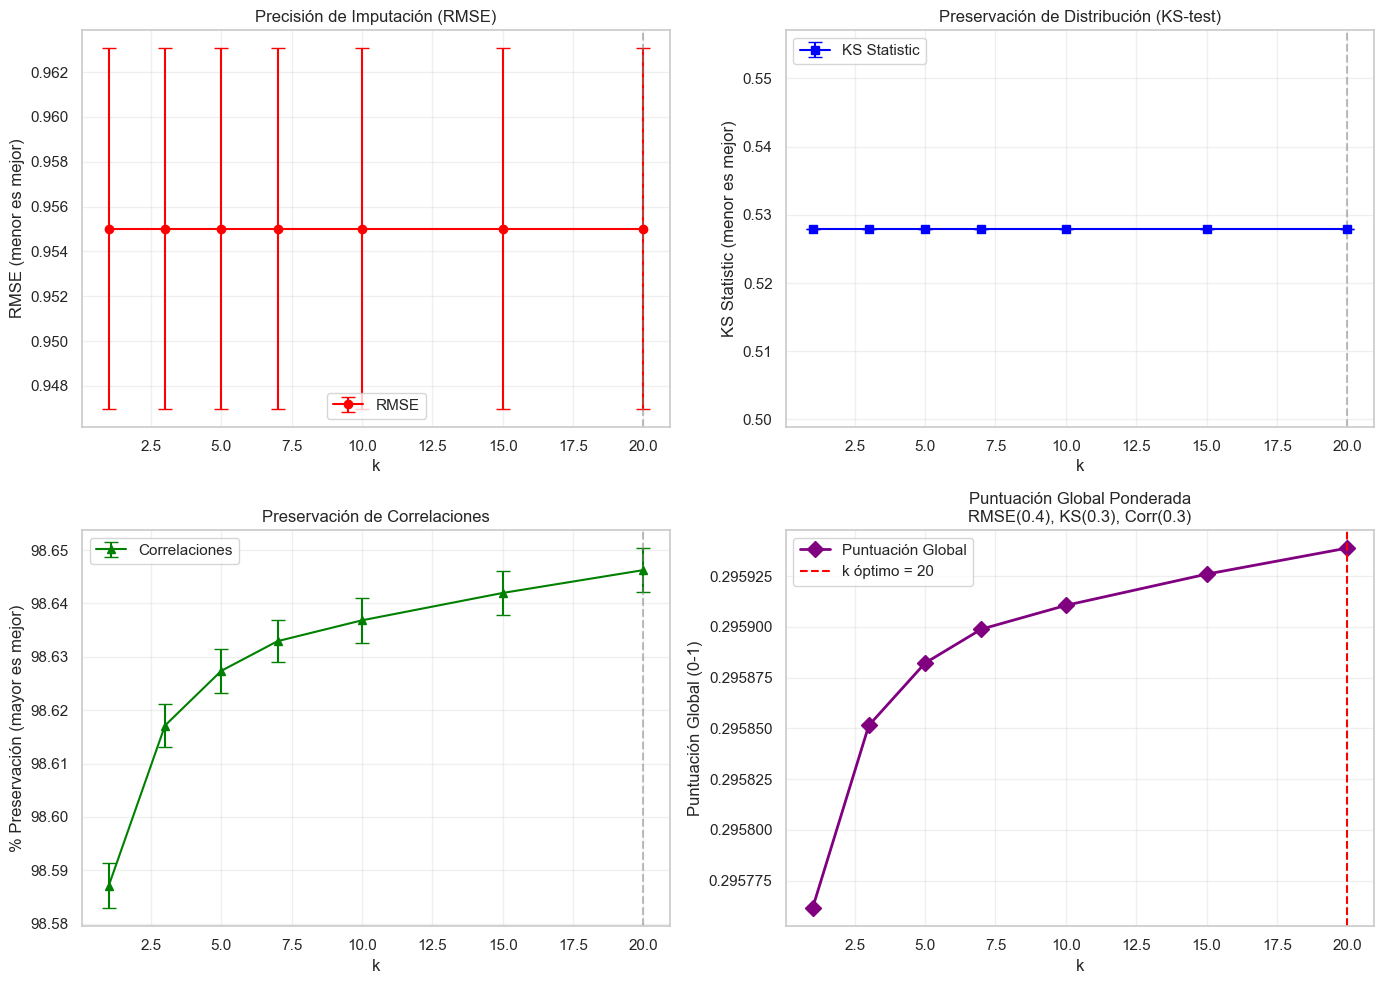

In [24]:
# Realizo las gráficas de resultados
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE
axes[0, 0].errorbar(results['k'], results['rmse_mean'], yerr=results['rmse_std'],
                   marker='o', capsize=5, color='red', label='RMSE')
axes[0, 0].axvline(x=optimal_k, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('k')
axes[0, 0].set_ylabel('RMSE (menor es mejor)')
axes[0, 0].set_title('Precisión de Imputación (RMSE)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# KS Statistic
axes[0, 1].errorbar(results['k'], results['ks_stat_mean'], yerr=results['ks_stat_std'],
                   marker='s', capsize=5, color='blue', label='KS Statistic')
axes[0, 1].axvline(x=optimal_k, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('k')
axes[0, 1].set_ylabel('KS Statistic (menor es mejor)')
axes[0, 1].set_title('Preservación de Distribución (KS-test)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Preservación de Correlaciones
axes[1, 0].errorbar(results['k'], results['corr_preservation_mean'], 
                   yerr=results['corr_preservation_std'],
                   marker='^', capsize=5, color='green', label='Correlaciones')
axes[1, 0].axvline(x=optimal_k, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('k')
axes[1, 0].set_ylabel('% Preservación (mayor es mejor)')
axes[1, 0].set_title('Preservación de Correlaciones')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Puntuación Global
axes[1, 1].plot(results['k'], global_scores, marker='D', color='purple', 
               linewidth=2, markersize=8, label='Puntuación Global')
axes[1, 1].axvline(x=optimal_k, color='red', linestyle='--', 
                  label=f'k óptimo = {optimal_k}')
axes[1, 1].set_xlabel('k')
axes[1, 1].set_ylabel('Puntuación Global (0-1)')
axes[1, 1].set_title(f'Puntuación Global Ponderada\nRMSE({weights["rmse"]}), KS({weights["ks"]}), Corr({weights["corr"]})')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()
plt.close()

In [25]:
# Entreno el imputador final con k óptimo usando todos los datos de entrenamiento
final_imputer = KNNImputer(
    n_neighbors=optimal_k,
    weights='distance',
    metric='nan_euclidean'
)

# Guardo el imputer y el scaler para su reproceso si fuera necesario
with open(os.path.join(DRIVE_PATH, "knn_imputer.pkl"), "wb") as f:
    pickle.dump(final_imputer, f)

with open(os.path.join(DRIVE_PATH, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

In [26]:
# Procedo a imputar los datos de entrenamiento

# Imputo con datos ESTANDARIZADOS
X_train_scaled_imputed = final_imputer.fit_transform(X_train_scaled)

# Revierto a escala original para facilitar XAI
X_train_num = pd.DataFrame(
    scaler.inverse_transform(X_train_scaled_imputed),  
    columns=numerical_features,
    index=df_train.index
)

# Almaceno el df en disco
save_csv(X_TRAIN, X_train_num)

# Aplico la transformación a Val, Cal y Test
datasets = {
    'val': (df_val, X_VAL),
    'cal': (df_cal, X_CAL),
    'test': (df_test, X_TEST)
}

def transform_and_impute(df, path, name):
    log(f"Transformando df {name}.")

    # Estandarizo usando el scaler ajustado con Train
    X_scaled = pd.DataFrame(
        scaler.transform(df[numerical_features]),
        columns=numerical_features,
        index=df.index
    )

    # Imputo
    X_scaled_imputed = final_imputer.transform(X_scaled)

    # Revierto a escala original
    X_num = pd.DataFrame(
        scaler.inverse_transform(X_scaled_imputed), 
        columns=numerical_features,
        index=df.index
    )
    # Almaceno el df en disco
    save_csv(path, X_num)
    
    return X_num

X_val_num = transform_and_impute(df_val, X_VAL, 'val')
X_cal_num = transform_and_impute(df_cal, X_CAL, 'cal')
X_test_num = transform_and_impute(df_test, X_TEST, 'test')  

log("Imputación completada con KNN. Datos en escala original.")

# Muestro las formas
print(X_train_num.shape)
print(X_val_num.shape)
print(X_cal_num.shape)
print(X_test_num.shape)

Fichero en D:\Desarrollo\TFG\EchoNext_X_train.csv almacenado.
[2025-12-12 21:49:39] Transformando df val.
Fichero en D:\Desarrollo\TFG\EchoNext_X_val.csv almacenado.
[2025-12-12 21:49:43] Transformando df cal.
Fichero en D:\Desarrollo\TFG\EchoNext_X_cal.csv almacenado.
[2025-12-12 21:49:49] Transformando df test.
Fichero en D:\Desarrollo\TFG\EchoNext_X_test.csv almacenado.
[2025-12-12 21:50:00] Imputación completada con KNN. Datos en escala original.
(65878, 60)
(2053, 60)
(2053, 60)
(4815, 60)


Se combinan los df de features en uno y se crean las variables objetivo.

In [27]:
# Creo los DF finales uniendo numéricos y categóricos
X_train_full = pd.concat([X_train_num, df_train[CATEGORICAL_ENCODED]], axis=1).drop(columns=[TARGET])
X_val_full = pd.concat([X_val_num, df_val[CATEGORICAL_ENCODED]], axis=1).drop(columns=[TARGET])
X_cal_full = pd.concat([X_cal_num, df_cal[CATEGORICAL_ENCODED]], axis=1).drop(columns=[TARGET])
X_test_full = pd.concat([X_test_num, df_test[CATEGORICAL_ENCODED]], axis=1).drop(columns=[TARGET])

# Creo las variables objetivo
y_train = df_train[TARGET]
y_val = df_val[TARGET]
y_cal = df_cal[TARGET]
y_test = df_test[TARGET]

del df_train, df_val, df_cal, df_test, X_train_num, X_val_num, X_cal_num, X_test_num # Libero la memoria

# Muestro las formas
print(X_train_full.shape)
print(X_val_full.shape)
print(X_cal_full.shape)
print(X_test_full.shape)

(65878, 62)
(2053, 62)
(2053, 62)
(4815, 62)


#### Reducción de características
Se van a estudiar los datos obtenidos e intentar reducir el número de características.
- Análisis de outliers
- Variance threshold
- Correlation removal

**Análisis de outliers**

Son valores atípicos que se desvían significativamente del resto. En datos médicos, pueden ser:
* Errores de medición: Deben corregirse o eliminarse
* Casos clínicos reales: Pacientes con condiciones extremas

Métodos de detección:
* IQR (Interquartile Range): Detecta valores fuera de Q1-1.5×IQR o Q3+1.5×IQR
* Z-score: Detecta valores con |z| > 3 (más de 3 desviaciones estándar)

En datos de electrocardiograma, los valores extremos pueden representar condiciones cardíacas reales (arritmias, hipertrofia, etc.). Por tanto, es conveniente mantener todos los datos.

[16]

Top 20 variables con más outliers
                   Variable  N_Outliers  Pct_Outliers  N_Outliers_Zscore  \
0            V1_Q_Amplitude        7449     11.307265               1602   
1    V1_R_Peak_MaxAmplitude        7358     11.169131               2191   
2            V1_R_Amplitude        7087     10.757764               2153   
3   V1_R_Peak_MeanAmplitude        7087     10.757764               2153   
4            V1_T_Amplitude        5374      8.157503               1405   
5            II_S_Amplitude        5014      7.611039               1707   
6           aVL_S_Amplitude        4348      6.600079               1553   
7           aVL_Q_Amplitude        3501      5.314369               1092   
8            V5_S_Amplitude        3436      5.215702               1357   
9             V1_P_Duration        3086      4.684417               1014   
10           V1_P_Amplitude        3004      4.559944                791   
11          aVL_T_Amplitude        2916      4.426364 

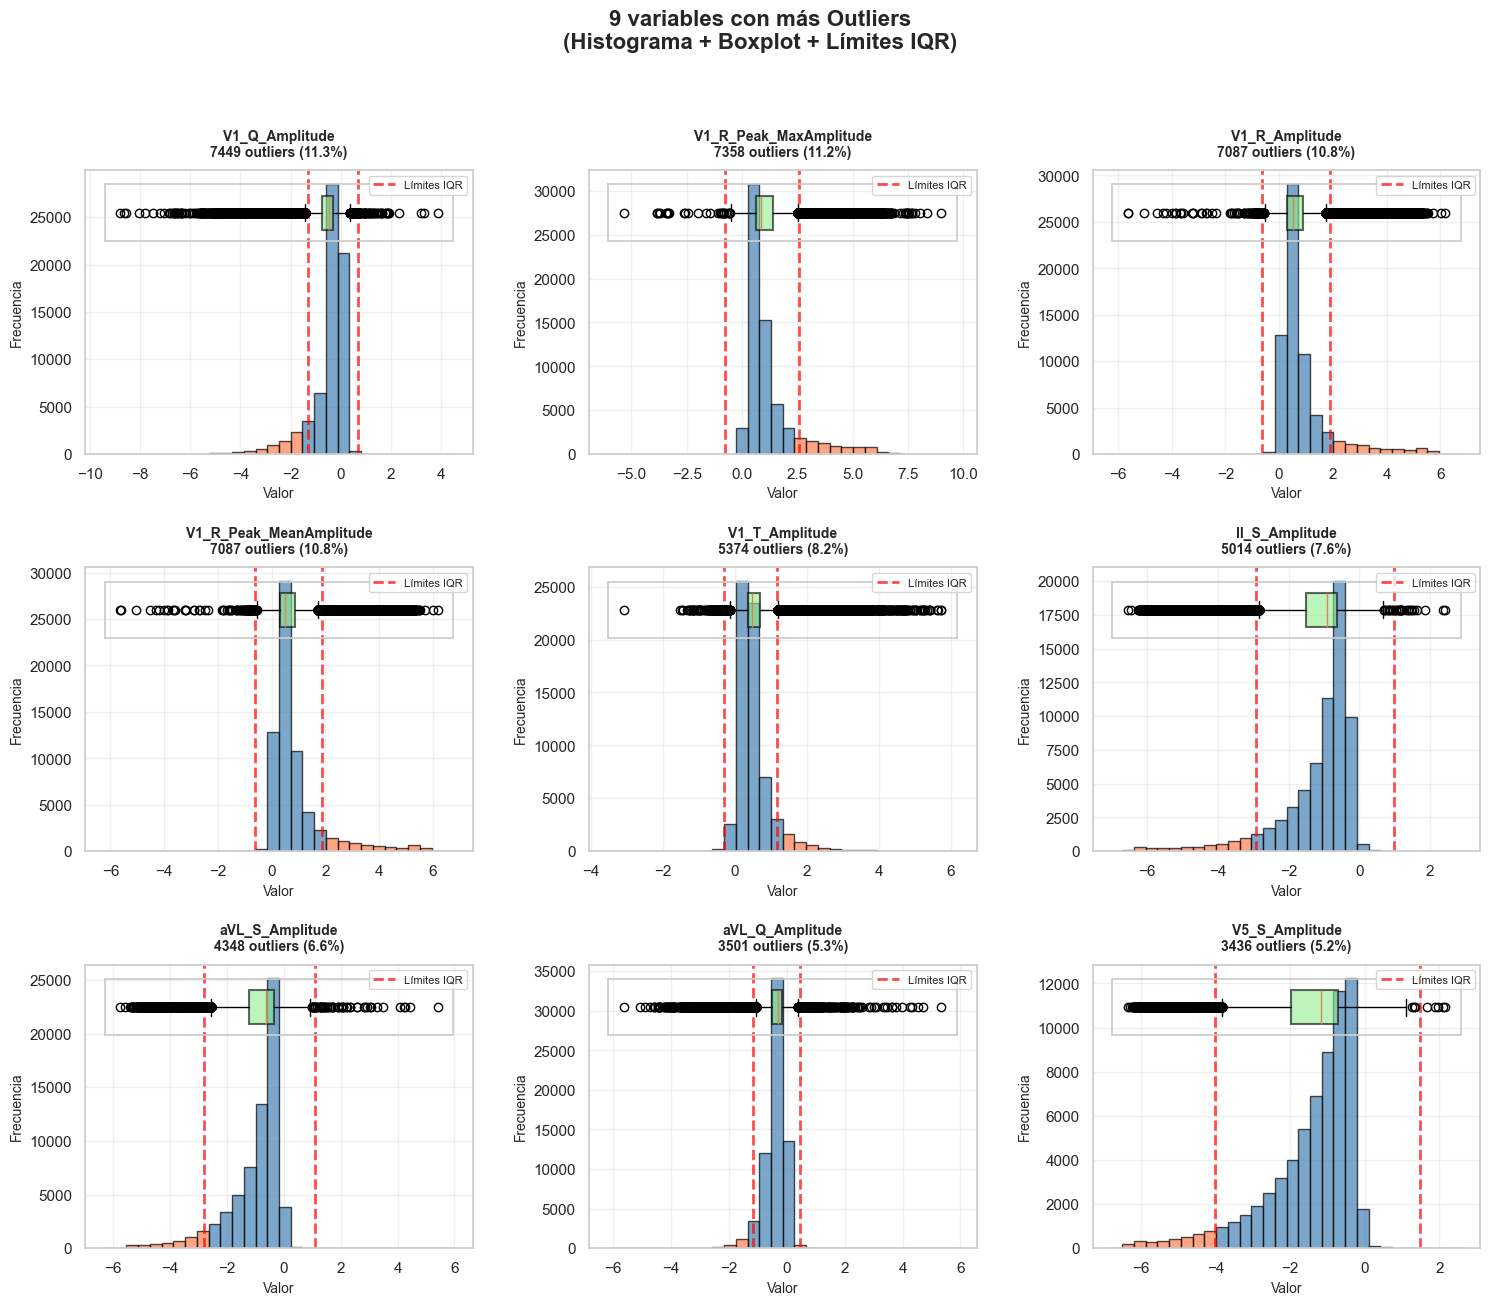

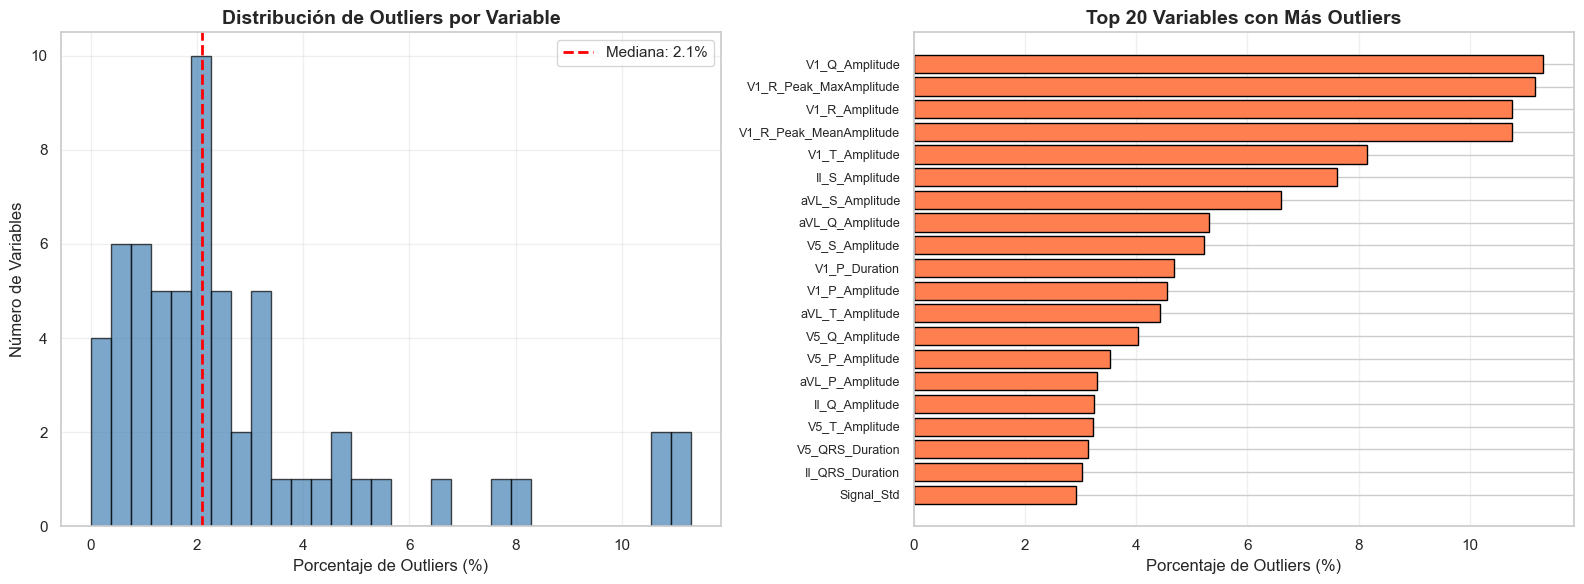

In [28]:
# Defino todas las features con las que se va a trabajar
all_features = X_train_full.columns.tolist()

# Funciones para detección de outliers
# Función para detectar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_report = []
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        n_outliers = outliers_mask.sum()
        pct_outliers = (n_outliers / len(df)) * 100
        
        outliers_report.append({
            'Variable': col,
            'N_Outliers': n_outliers,
            'Pct_Outliers': pct_outliers,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound,
            'Min': df[col].min(),
            'Max': df[col].max()
        })
    
    return pd.DataFrame(outliers_report).sort_values('Pct_Outliers', ascending=False)

# Función para detectar outliers usando Z-score
def detect_outliers_zscore(df, columns, threshold=3):
    outliers_report = []
    
    for col in columns:
        z_scores = np.abs(stats.zscore(df[col], nan_policy='omit'))
        n_outliers = (z_scores > threshold).sum()
        pct_outliers = (n_outliers / len(df)) * 100
        
        outliers_report.append({
            'Variable': col,
            'N_Outliers_Zscore': n_outliers,
            'Pct_Outliers_Zscore': pct_outliers
        })
    
    return pd.DataFrame(outliers_report).sort_values('Pct_Outliers_Zscore', ascending=False)

# Detecto los outliers con ambos métodos
outliers_iqr = detect_outliers_iqr(X_train_full, all_features)
outliers_zscore = detect_outliers_zscore(X_train_full, all_features, threshold=3)
outliers_full = outliers_iqr.merge(outliers_zscore, on='Variable')
del outliers_iqr, outliers_zscore  # Libero memoria

# Muestro el top 20 variables con más outliers
print(f"Top 20 variables con más outliers")
print(outliers_full[['Variable', 'N_Outliers', 'Pct_Outliers', 'N_Outliers_Zscore', 'Pct_Outliers_Zscore']].head(20))

# Genero las visualizaciones de outliers usando boxplots
# Selecciono las 9 variables con más outliers
top_outlier_vars = outliers_full.head(9)['Variable'].tolist()

fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

for idx, col in enumerate(top_outlier_vars):
    row = idx // 3
    col_pos = idx % 3
    
    # Creo un subgrid para cada variable (histograma + boxplot)
    subfig = fig.add_subplot(gs[row, col_pos])
    
    # Obtengo los datos
    data = X_train_full[col].dropna()
    pct = outliers_full[outliers_full['Variable'] == col]['Pct_Outliers'].values[0]
    n_out = outliers_full[outliers_full['Variable'] == col]['N_Outliers'].values[0]
    lower = outliers_full[outliers_full['Variable'] == col]['Lower_Bound'].values[0]
    upper = outliers_full[outliers_full['Variable'] == col]['Upper_Bound'].values[0]
    
    # Genero un histograma
    n, bins, patches = subfig.hist(data, bins=30, color='steelblue', 
                                   edgecolor='black', alpha=0.7)
    
    # Coloreo los outliers en el histograma
    for j, patch in enumerate(patches):
        bin_center = (bins[j] + bins[j+1]) / 2
        if bin_center < lower or bin_center > upper:
            patch.set_facecolor('coral')
    
    # Incluyo la líneas de límites IQR
    subfig.axvline(lower, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Límites IQR')
    subfig.axvline(upper, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # Añado un boxplot pequeño en la parte superior
    # Creo un eje secundario para el boxplot
    divider_pos = 0.75
    ax_box = subfig.inset_axes([0.05, divider_pos, 0.9, 0.2])
    bp = ax_box.boxplot(data, vert=False, widths=0.6, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][0].set_alpha(0.6)
    bp['boxes'][0].set_edgecolor('black')
    bp['boxes'][0].set_linewidth(1.5)
    
    # Configuro el boxplot
    ax_box.set_yticks([])
    ax_box.set_xticks([])
    ax_box.set_xlim(subfig.get_xlim())
    ax_box.patch.set_alpha(0)
    
    subfig.set_xlabel('Valor', fontsize=10)
    subfig.set_ylabel('Frecuencia', fontsize=10)
    subfig.set_title(f'{col}\n{n_out} outliers ({pct:.1f}%)', 
                    fontsize=10, fontweight='bold', pad=10)
    subfig.legend(fontsize=8, loc='upper right')
    subfig.grid(True, alpha=0.3)

plt.suptitle('9 variables con más Outliers\n(Histograma + Boxplot + Límites IQR)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()
plt.close()

# Genero las visualizaciones de distribución de outliers
# Defino la figura y los ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histograma
ax1.hist(outliers_full['Pct_Outliers'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(outliers_full['Pct_Outliers'].median(), color='red', linestyle='--', linewidth=2, label=f'Mediana: {outliers_full["Pct_Outliers"].median():.1f}%')
ax1.set_xlabel('Porcentaje de Outliers (%)', fontsize=12)
ax1.set_ylabel('Número de Variables', fontsize=12)
ax1.set_title('Distribución de Outliers por Variable', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Barplot horizontal de top 20
top_20 = outliers_full.head(20)
ax2.barh(range(len(top_20)), top_20['Pct_Outliers'], color='coral', edgecolor='black')
ax2.set_yticks(range(len(top_20)))
ax2.set_yticklabels(top_20['Variable'], fontsize=9)
ax2.set_xlabel('Porcentaje de Outliers (%)', fontsize=12)
ax2.set_title('Top 20 Variables con Más Outliers', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

**Variance threshold**

Elimina variables con varianza muy baja (casi constantes). Si una variable tiene el mismo valor en el 99% de los casos, aporta poca información predictiva.

Variables constantes no ayudan a discriminar entre clases, reducen dimensionalidad sin perder información útil y mejoran estabilidad del modelo.

Umbral típico: 0.01 (elimina variables con varianza < 1% de la varianza máxima normalizada)
[17]

Estadísticas de varianza:
 - Varianza mínima: 0.004085
 - Varianza máxima: 7869.21
 - Varianza mediana: 4.8306

Variables con menor varianza:
Signal_Mean        0.004085
aVL_P_Amplitude    0.045768
V5_P_Amplitude     0.051703
V1_P_Amplitude     0.062709
V5_Q_Amplitude     0.087986
II_P_Amplitude     0.094624
Signal_Std         0.111563
II_Q_Amplitude     0.118304
aVL_Q_Amplitude    0.196527
aVL_T_Amplitude    0.229107
dtype: float64
Resultados:
 - Variables mantenidas: 62
 - Variables eliminadas: 0

Ninguna variable eliminada (todas tienen varianza > umbral)


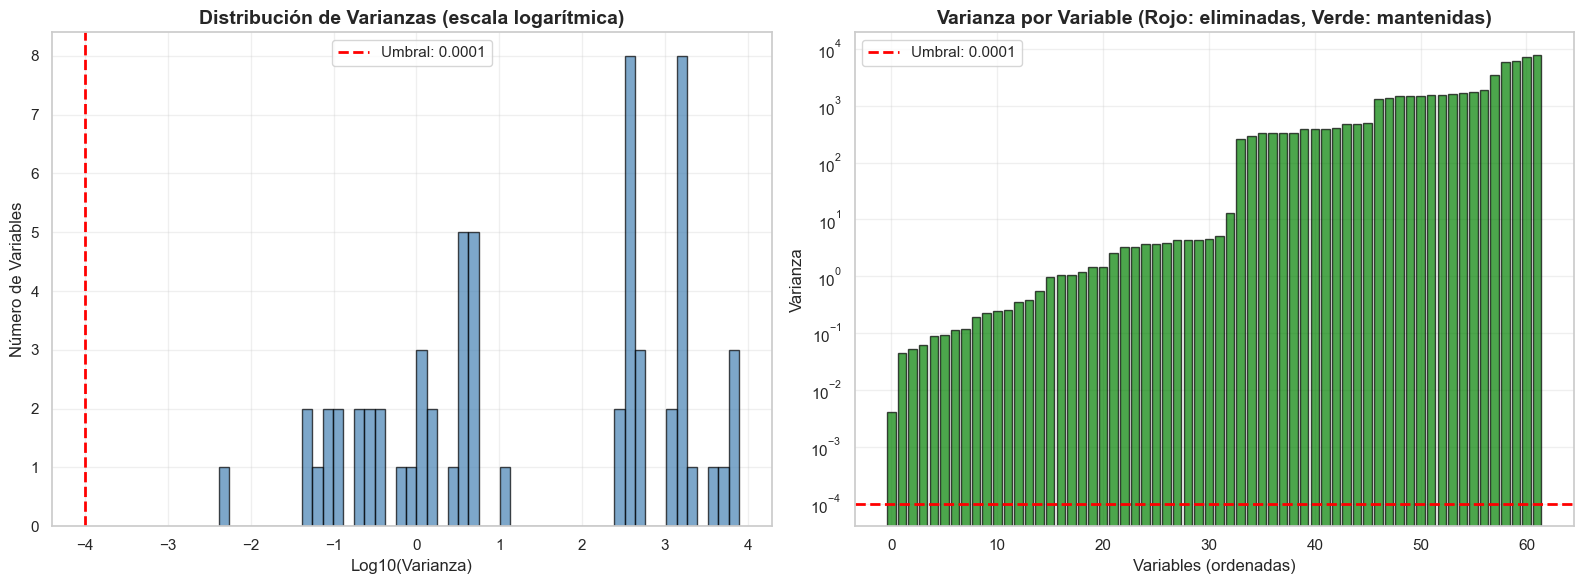

In [29]:
# Calculo la varianza de cada variable
variances = X_train_full.var().sort_values()

print(f"Estadísticas de varianza:")
print(f" - Varianza mínima: {variances.min():.6f}")
print(f" - Varianza máxima: {variances.max():.2f}")
print(f" - Varianza mediana: {variances.median():.4f}")

print("\nVariables con menor varianza:")
print(variances.head(10))

# Defino el umbral (1e-4 [17])
variance_threshold = 1e-4

# Creo el selector
selector_variance = VarianceThreshold(threshold=variance_threshold)
selector_variance.fit(X_train_full)

# Variables que pasan el filtro y las que no
selected_mask = selector_variance.get_support()
selected_variance_features = X_train_full.columns[selected_mask].tolist()
removed_variance_features = X_train_full.columns[~selected_mask].tolist()

print(f"Resultados:")
print(f" - Variables mantenidas: {len(selected_variance_features)}")
print(f" - Variables eliminadas: {len(removed_variance_features)}")

if removed_variance_features:
    print(f"Variables eliminadas por baja varianza:")
    for var in removed_variance_features:
        var_value = variances[var]
        print(f" - {var}: varianza = {var_value:.6f}")
else:
    print("\nNinguna variable eliminada (todas tienen varianza > umbral)")

# Aplico la transformación a todos los datasets
X_train_var = X_train_full[selected_variance_features]
X_val_var = X_val_full[selected_variance_features]
X_cal_var = X_cal_full[selected_variance_features]
X_test_var = X_test_full[selected_variance_features]
del X_train_full, X_val_full, X_cal_full, X_test_full  # Libero la memoria

# Muestro la distribución de las varianzas
# Defino la figura y los ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Distribución de varianzas (escala log)
ax1.hist(np.log10(variances + 1e-10), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(np.log10(variance_threshold), color='red', linestyle='--', linewidth=2, 
            label=f'Umbral: {variance_threshold}')
ax1.set_xlabel('Log10(Varianza)', fontsize=12)
ax1.set_ylabel('Número de Variables', fontsize=12)
ax1.set_title('Distribución de Varianzas (escala logarítmica)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Varianza ordenada de menor a mayor
sorted_vars = variances.sort_values()
colors = ['red' if v < variance_threshold else 'green' for v in sorted_vars]
ax2.bar(range(len(sorted_vars)), sorted_vars, color=colors, edgecolor='black', alpha=0.7)
ax2.axhline(variance_threshold, color='red', linestyle='--', linewidth=2, label=f'Umbral: {variance_threshold}')
ax2.set_xlabel('Variables (ordenadas)', fontsize=12)
ax2.set_ylabel('Varianza', fontsize=12)
ax2.set_title('Varianza por Variable (Rojo: eliminadas, Verde: mantenidas)', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

**Correlation removal**

La multicolinealidad es cuando dos o más variables están altamente correlacionadas. Es decir, miden casi lo mismo.

Motivos para eliminar las correlaciones altas:
- Redundancia: No aportan información nueva
- Inestabilidad: Coeficientes del modelo varían mucho
- Interpretabilidad: Difícil saber cuál variable es realmente importante

El umbral típico se considera entre 0.80-0.90 (correlación de Pearson)
[18]

Estadísticas de correlaciones:
 - Número de pares de variables: 1891
 - Correlación media: 0.132
 - Correlación máxima: 1.000
 - Pares con |r| > 0.7: 41
 - Pares con |r| > 0.8: 35
 - Pares con |r| > 0.9: 15
Los 10 pares de variables más correlacionadas:
1.000: aVL_R_Amplitude <-> aVL_R_Peak_MeanAmplitude
1.000: II_R_Amplitude <-> II_R_Peak_MeanAmplitude
1.000: V1_R_Amplitude <-> V1_R_Peak_MeanAmplitude
1.000: V5_R_Amplitude <-> V5_R_Peak_MeanAmplitude
0.958: aVL_R_Amplitude <-> aVL_R_Peak_MaxAmplitude
0.958: aVL_R_Peak_MeanAmplitude <-> aVL_R_Peak_MaxAmplitude
0.956: V5_R_Peak_MeanAmplitude <-> V5_R_Peak_MaxAmplitude
0.956: V5_R_Amplitude <-> V5_R_Peak_MaxAmplitude
0.937: II_Ventricular_Rate <-> V5_Ventricular_Rate
0.937: V5_Ventricular_Rate <-> aVL_Ventricular_Rate


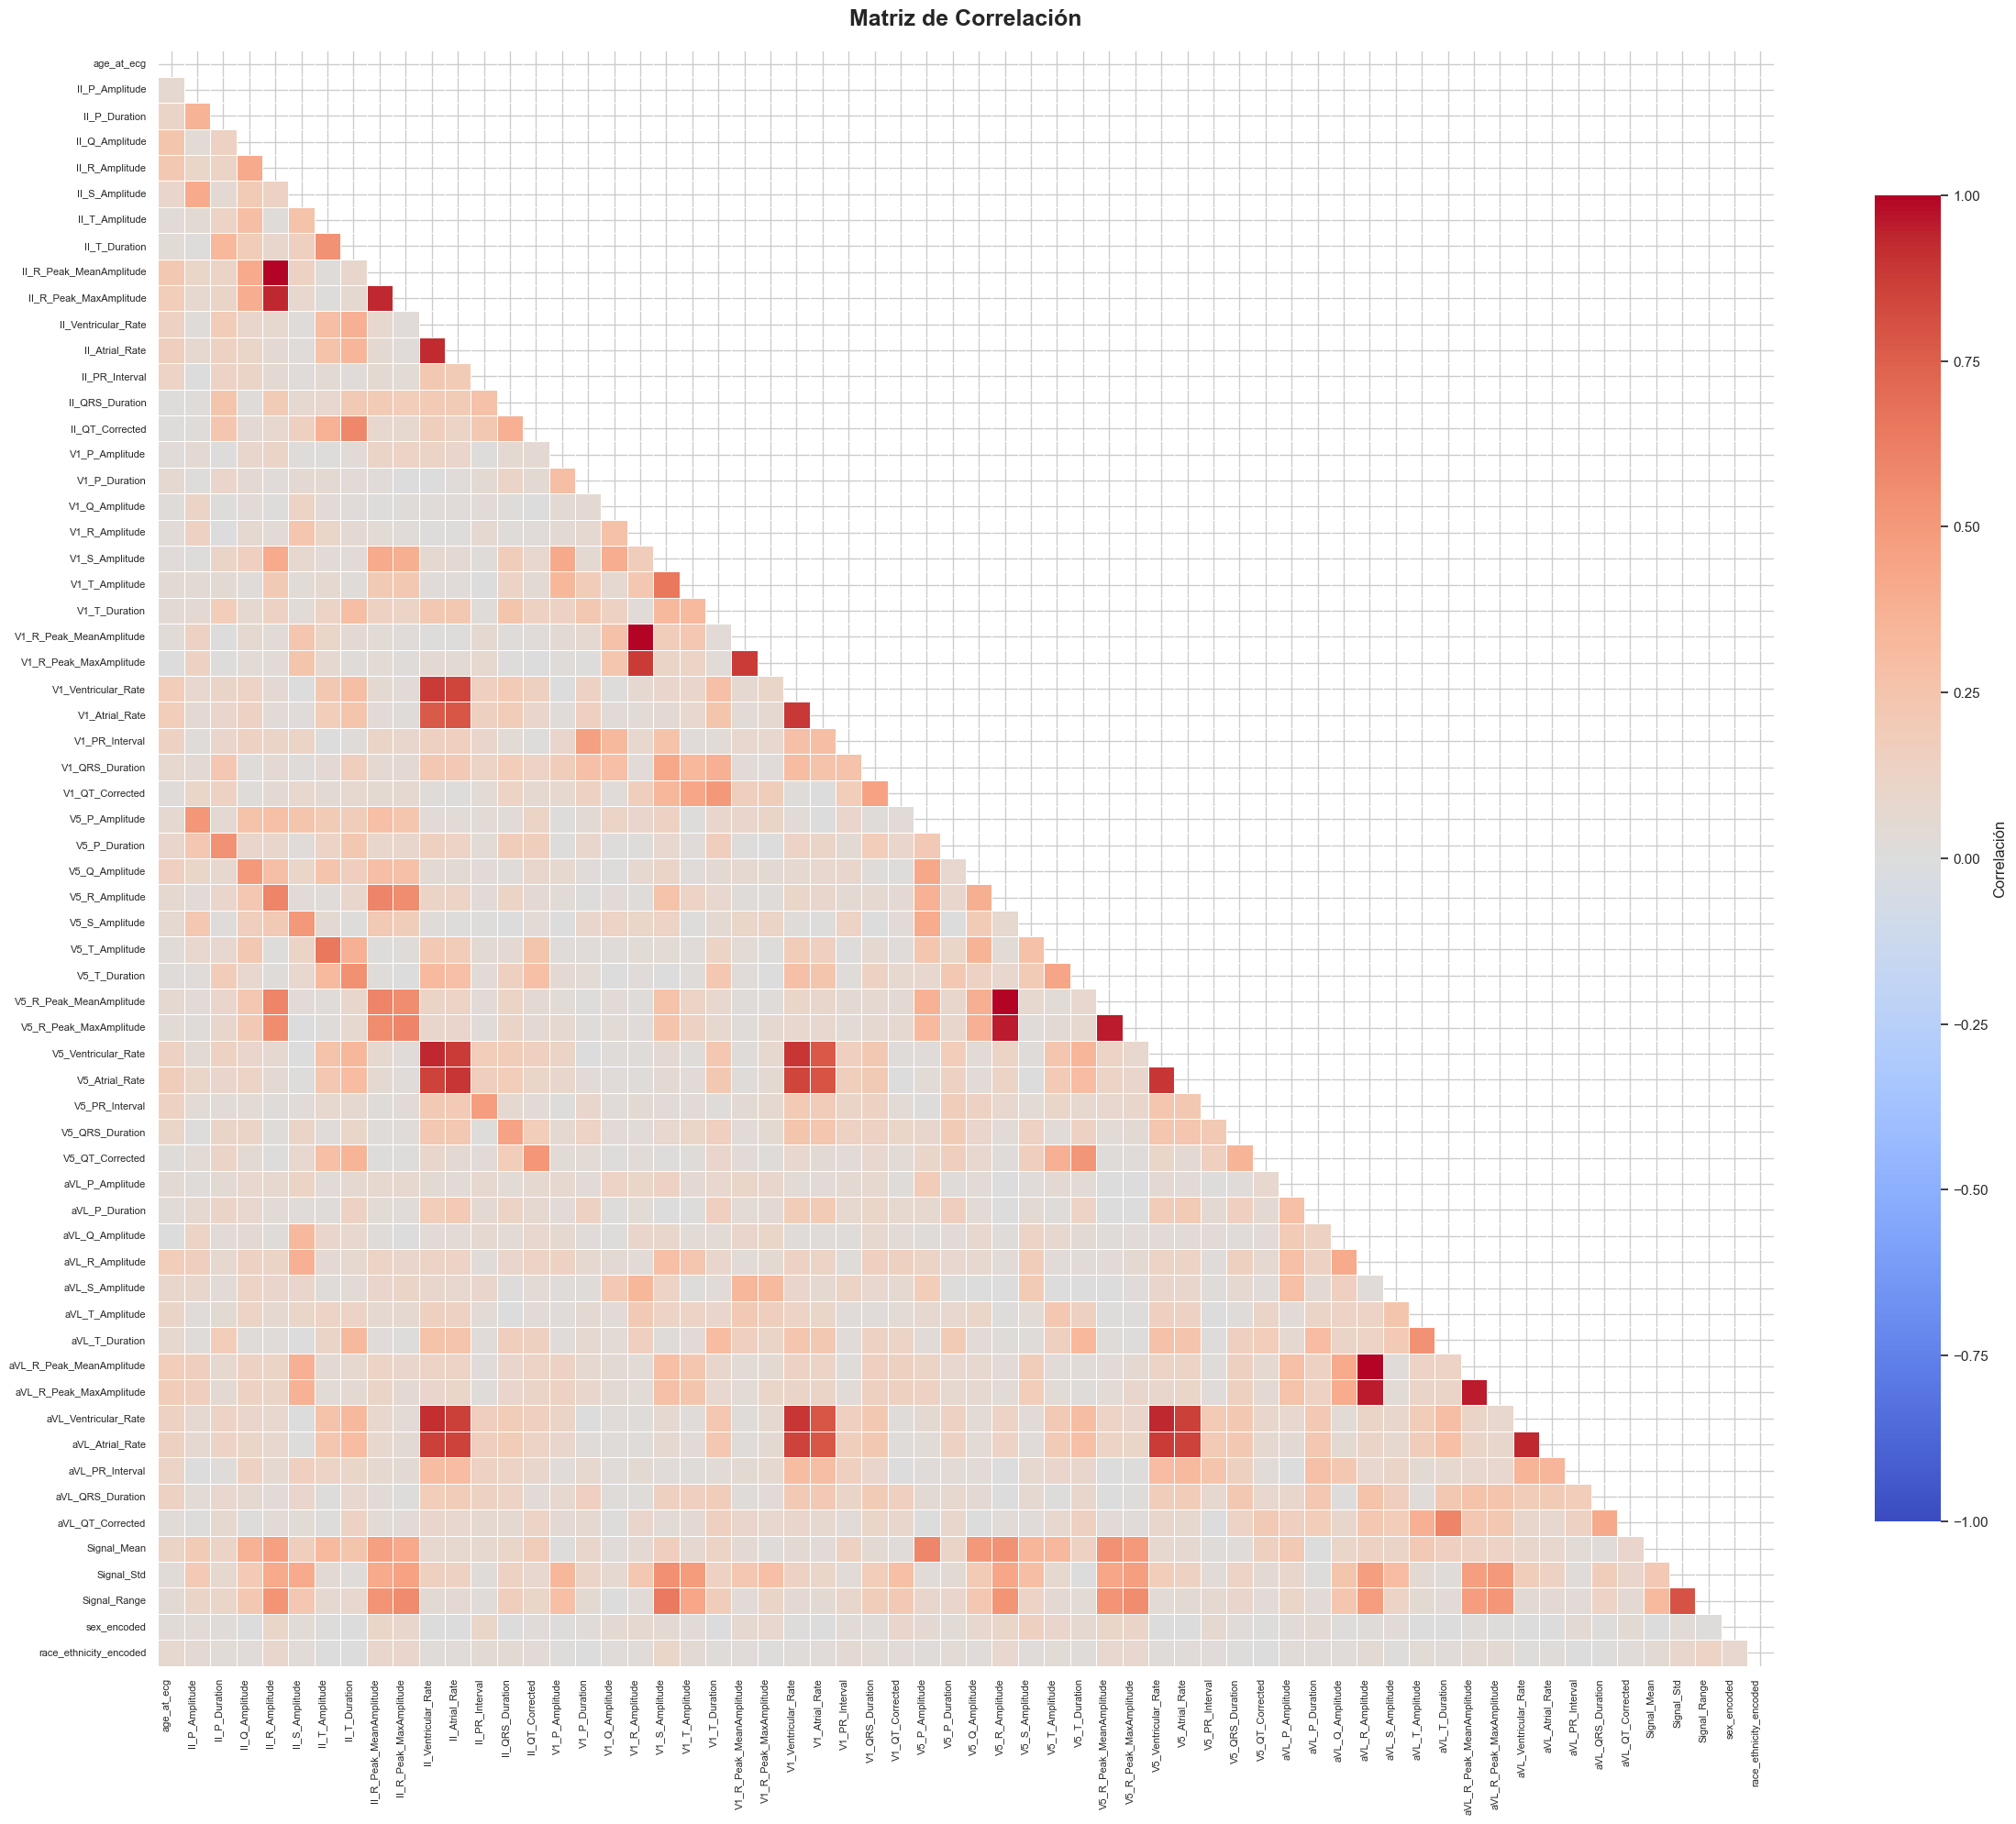

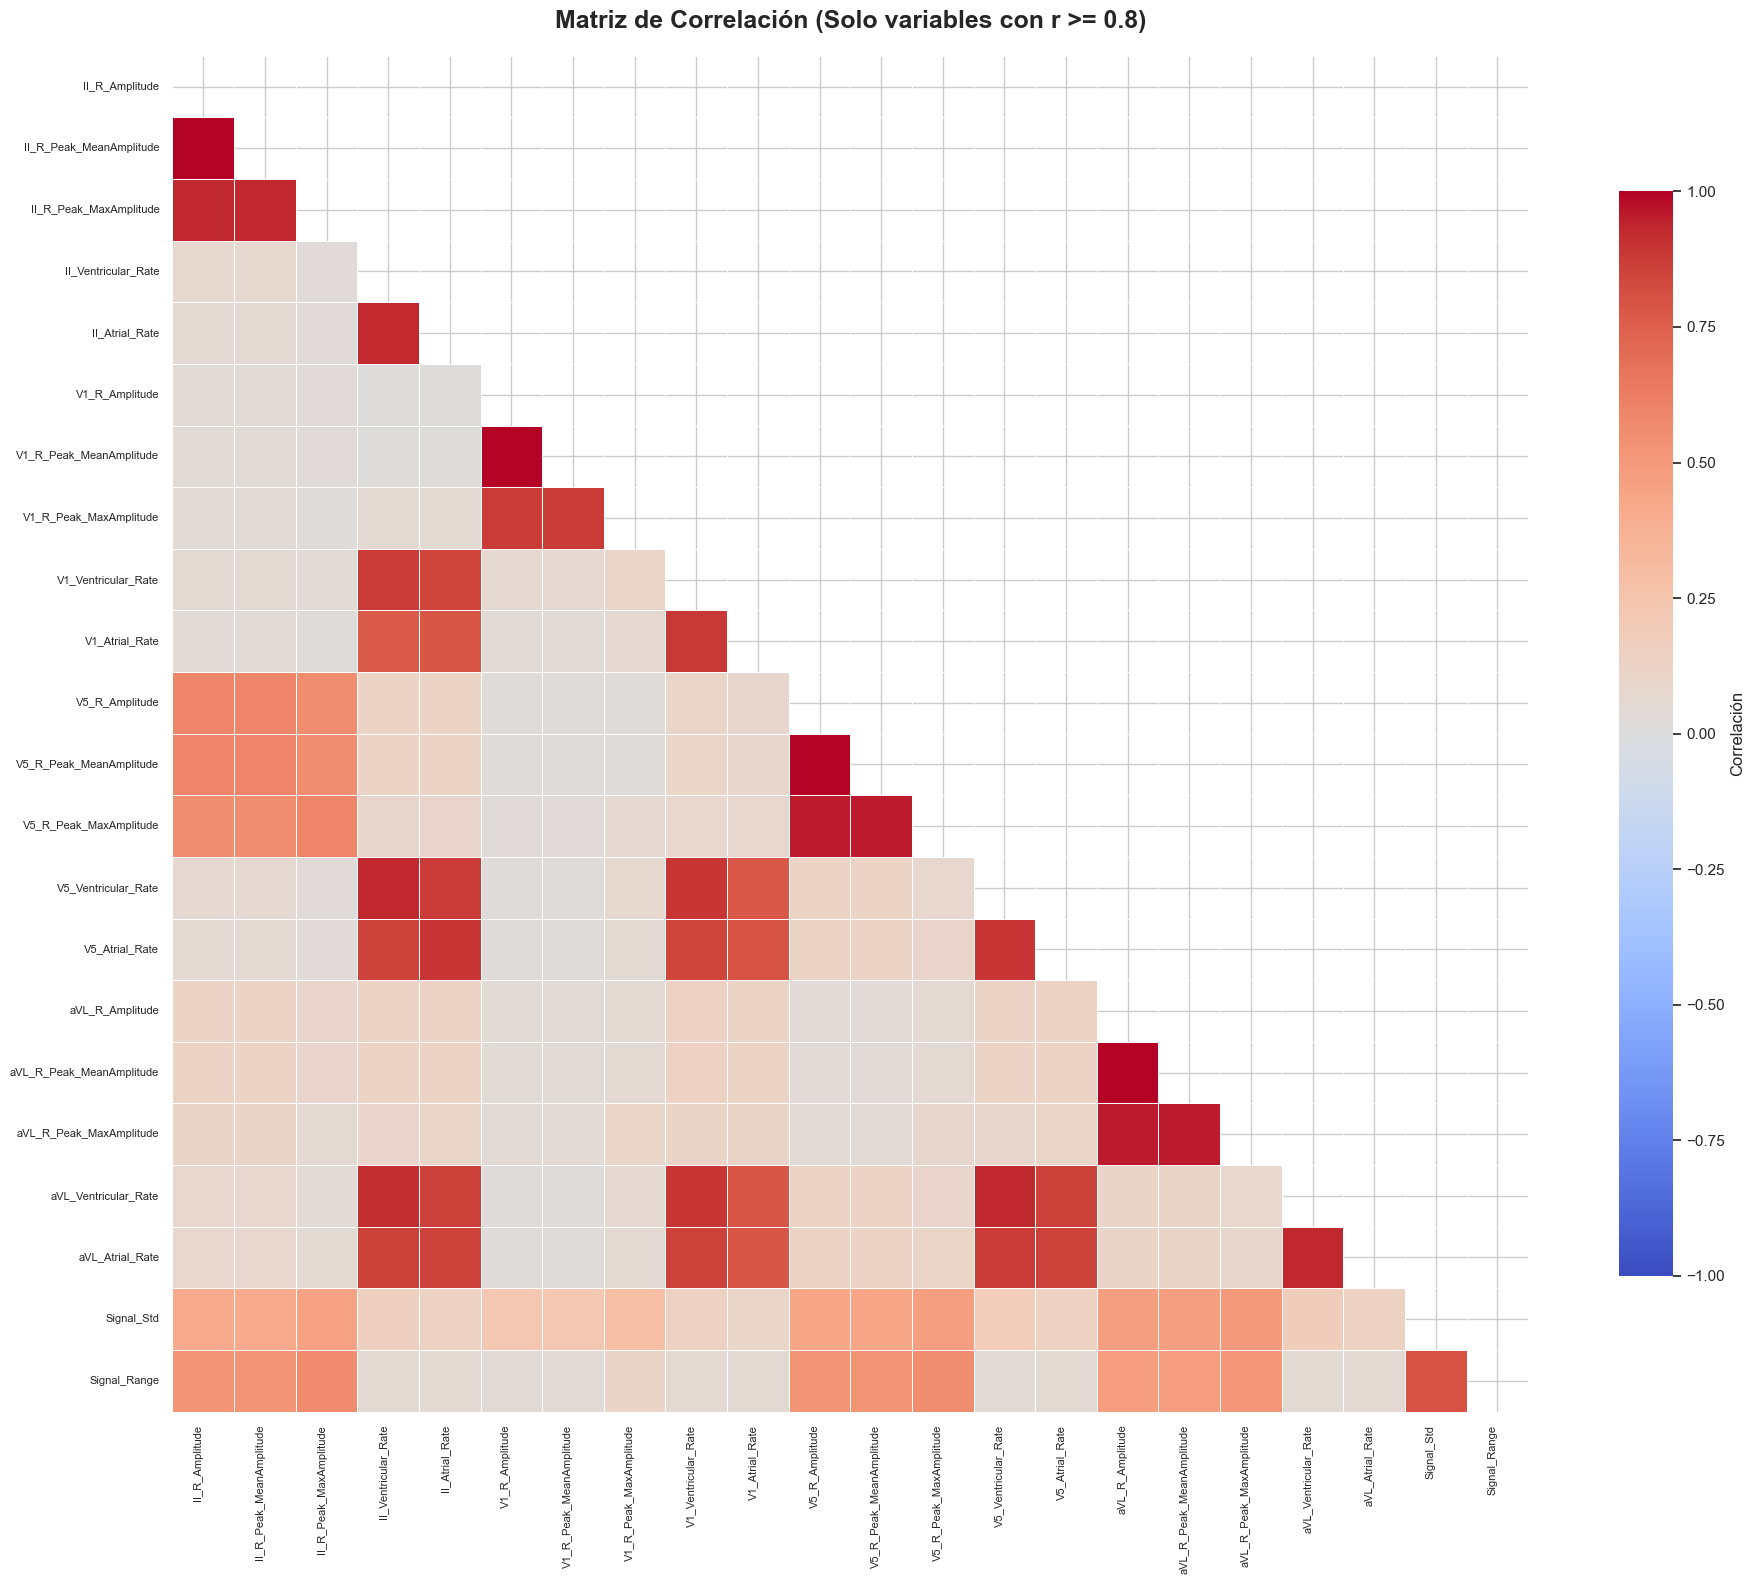

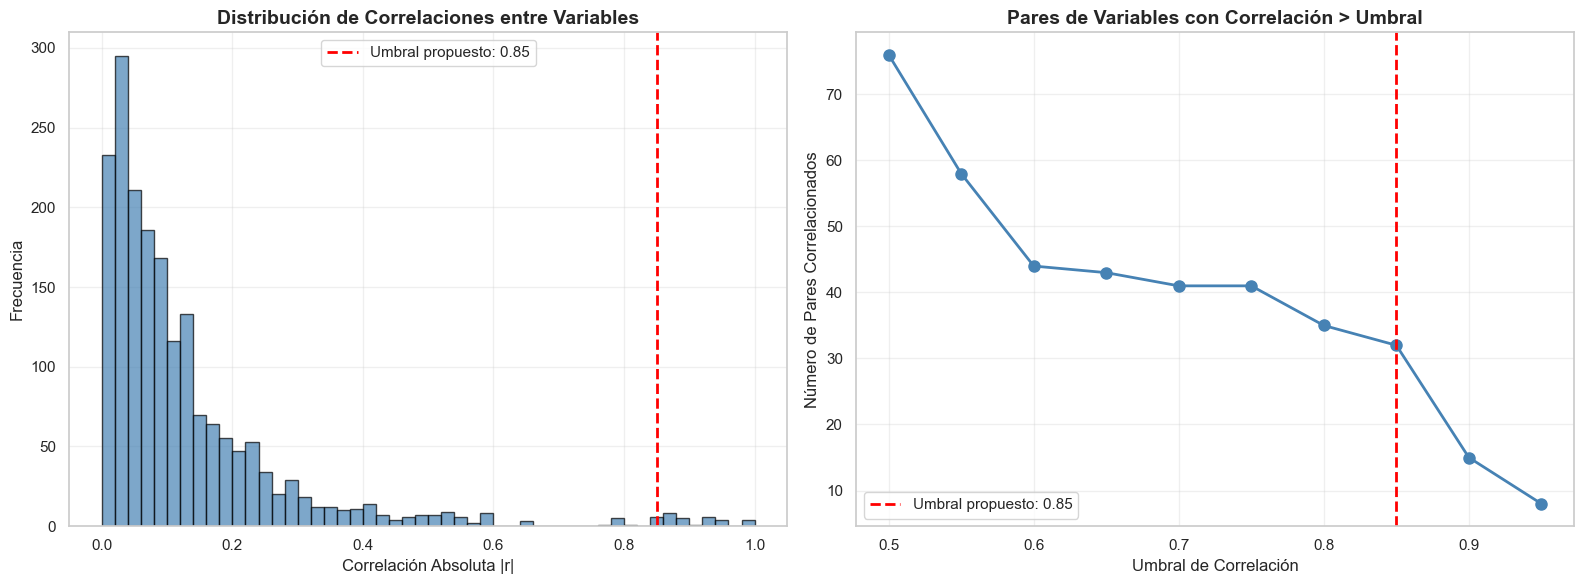

Resultados:
 - Variables eliminadas por alta correlación: 14
Variables eliminadas:
 - II_Atrial_Rate
 - II_R_Amplitude
 - II_R_Peak_MeanAmplitude
 - II_Ventricular_Rate
 - V1_R_Amplitude
 - V1_R_Peak_MeanAmplitude
 - V1_Ventricular_Rate
 - V5_R_Amplitude
 - V5_R_Peak_MeanAmplitude
 - V5_Ventricular_Rate
 - aVL_Atrial_Rate
 - aVL_R_Amplitude
 - aVL_R_Peak_MeanAmplitude
 - aVL_Ventricular_Rate
Pares con mayor correlación (eliminados):
      Variable_Eliminada       Variable_Mantenida  Correlacion
          II_R_Amplitude  II_R_Peak_MeanAmplitude     1.000000
          V1_R_Amplitude  V1_R_Peak_MeanAmplitude     1.000000
          V5_R_Amplitude  V5_R_Peak_MeanAmplitude     1.000000
         aVL_R_Amplitude aVL_R_Peak_MeanAmplitude     1.000000
         aVL_R_Amplitude  aVL_R_Peak_MaxAmplitude     0.958245
aVL_R_Peak_MeanAmplitude  aVL_R_Peak_MaxAmplitude     0.958245
 V5_R_Peak_MeanAmplitude   V5_R_Peak_MaxAmplitude     0.955611
          V5_R_Amplitude   V5_R_Peak_MaxAmplitude     0.955

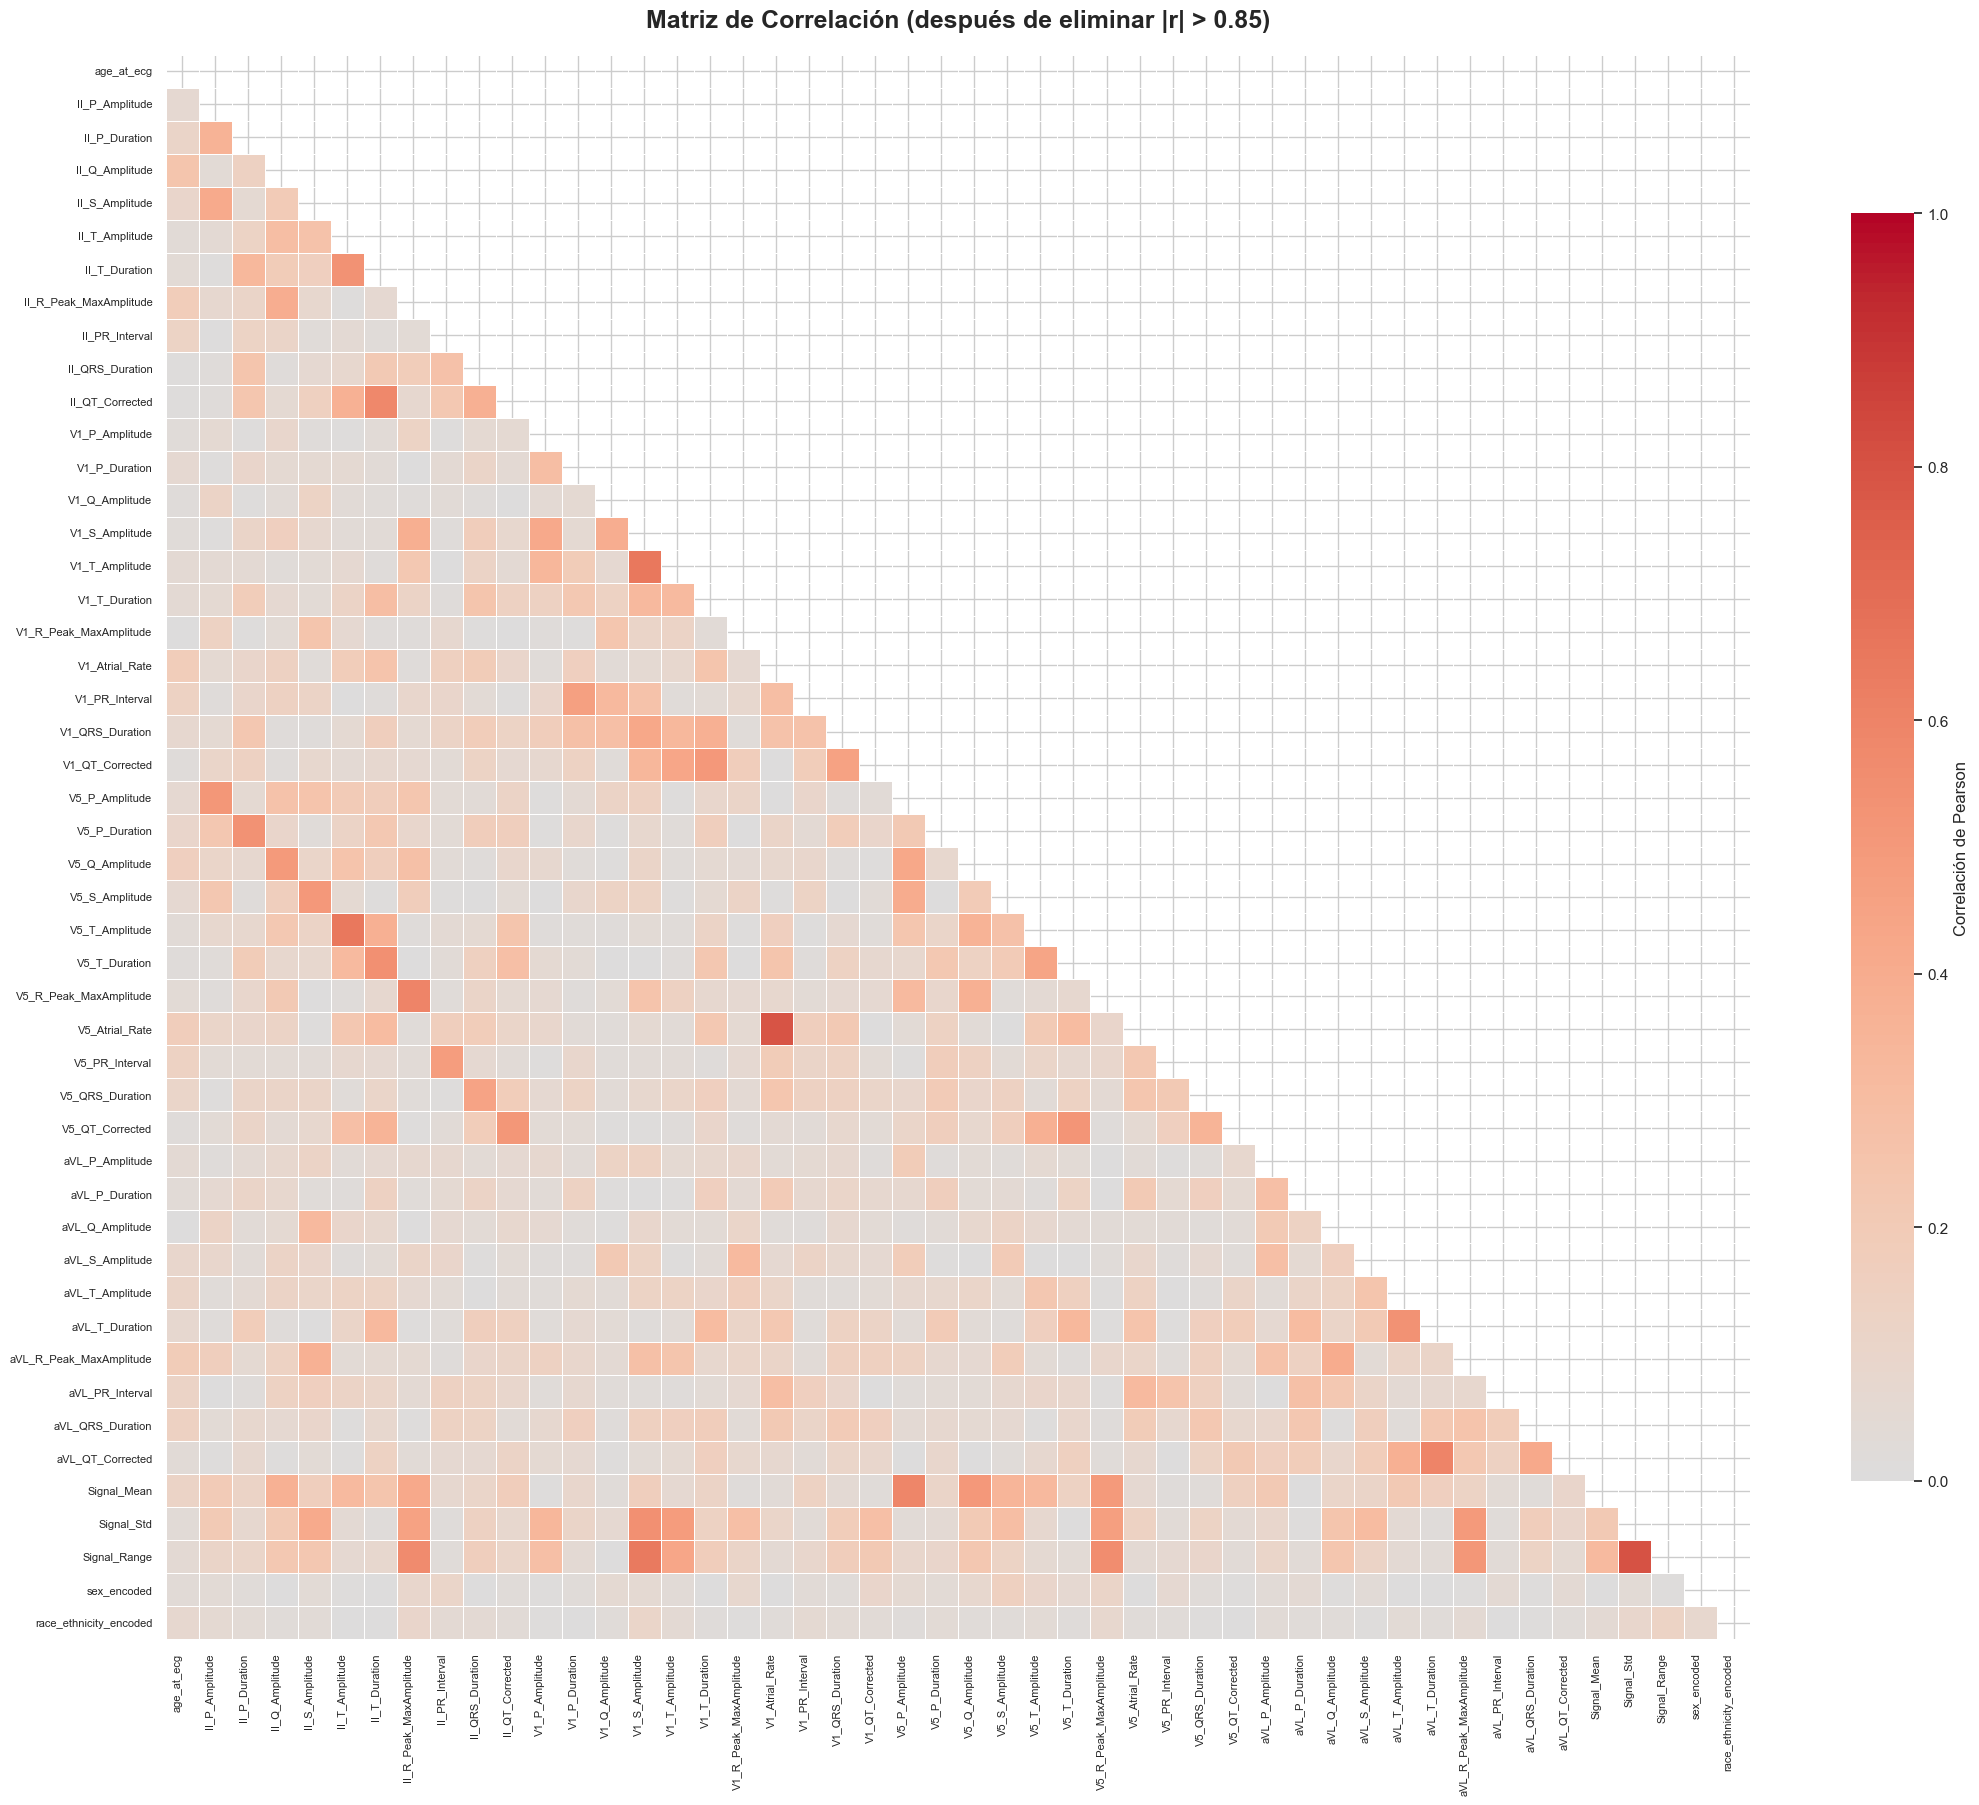

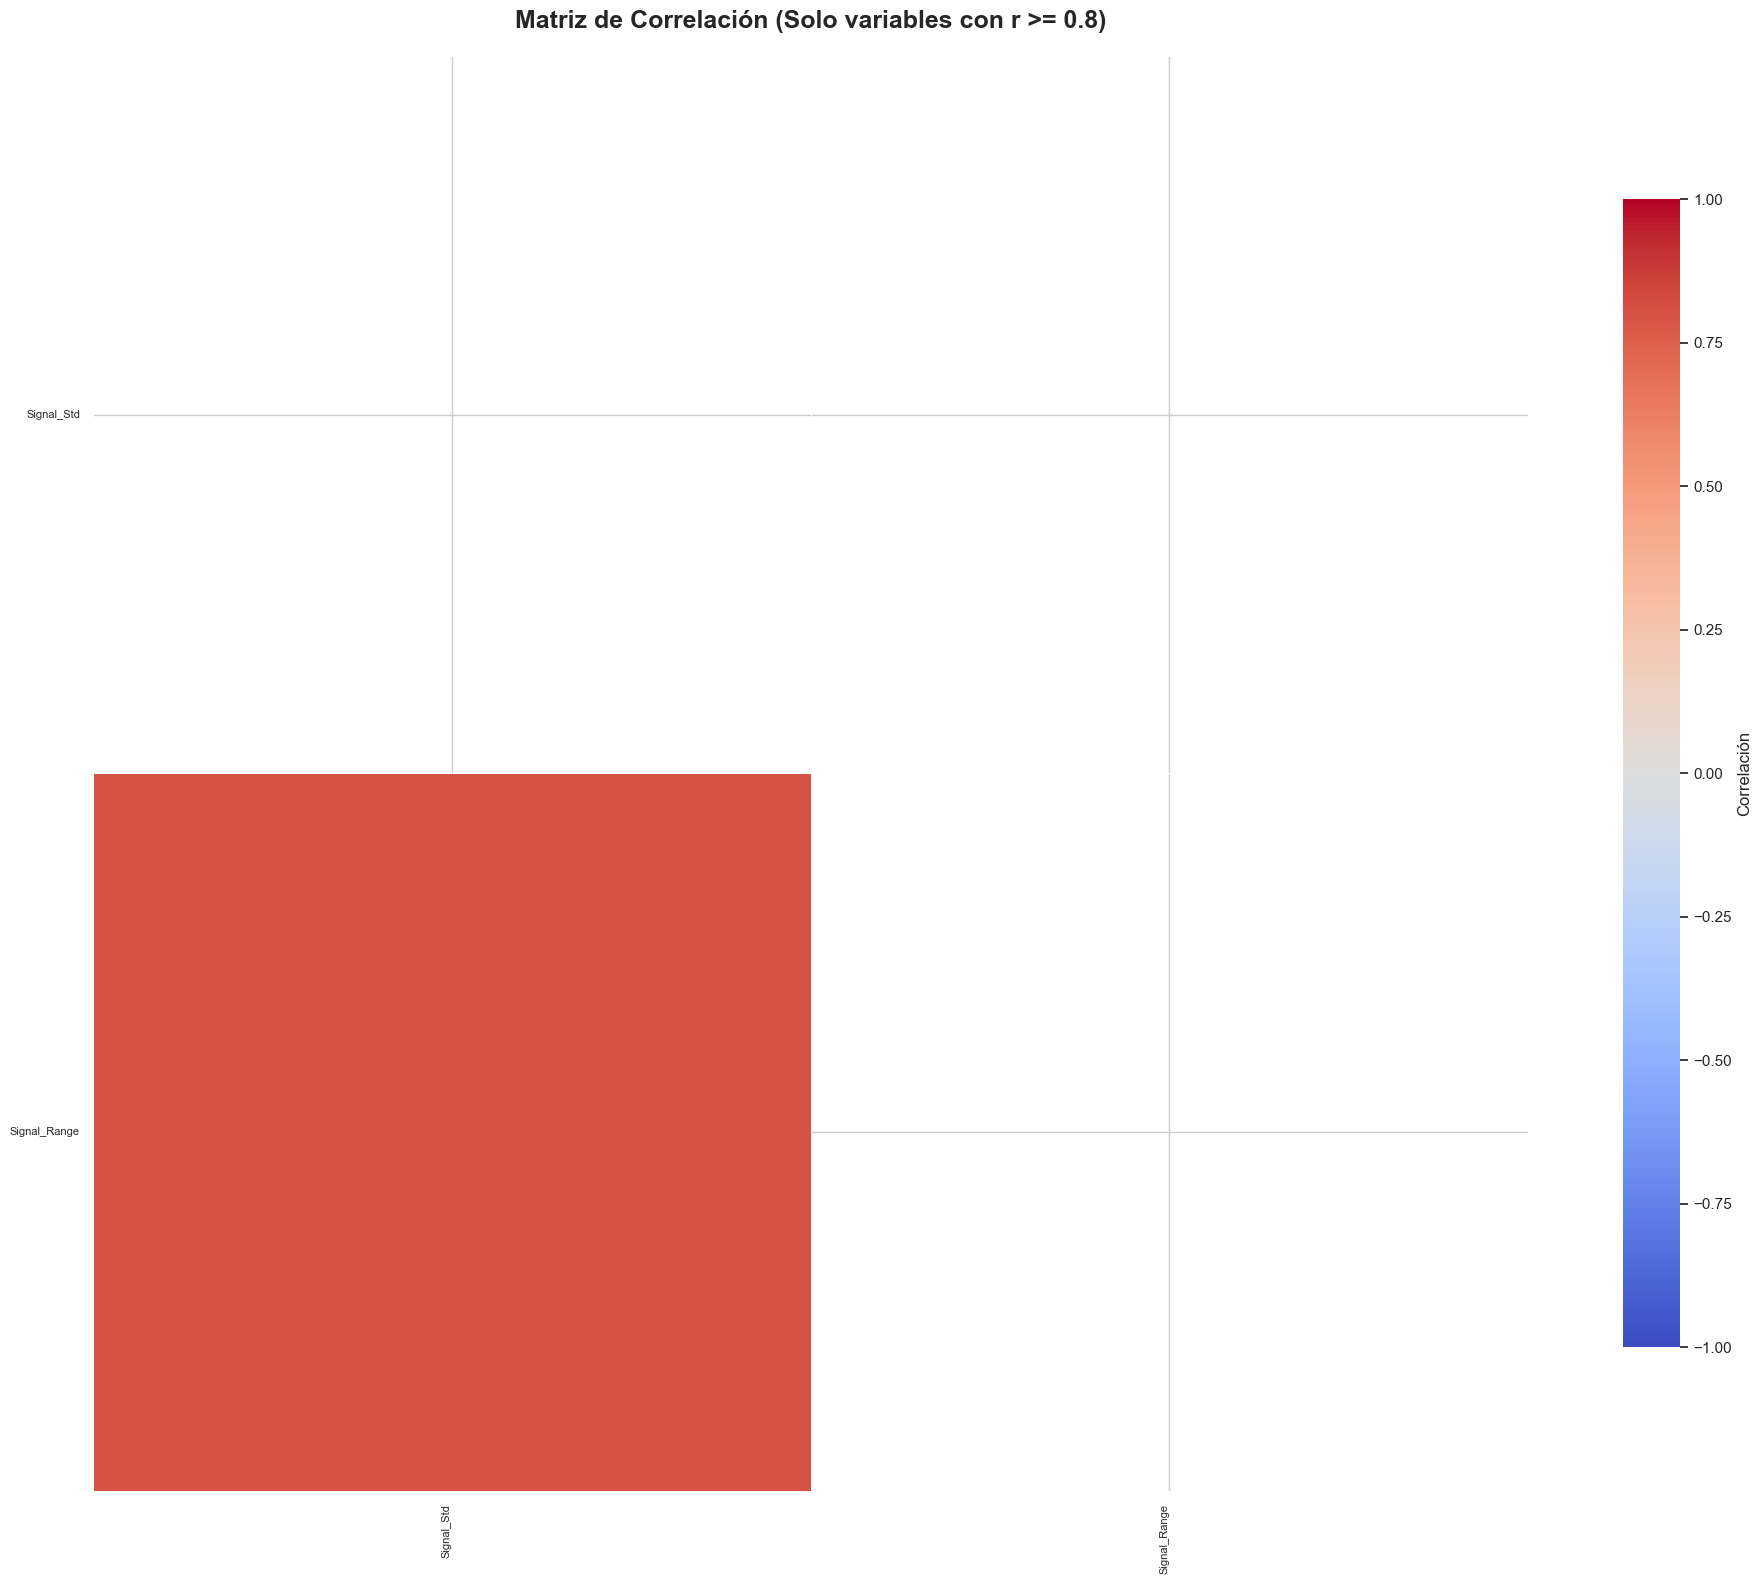

Estadísticas de correlaciones después de limpieza:
 - Correlación máxima restante: 0.801
 - Correlación media: 0.113
 - Pares con |r| > 0.85: 0


In [30]:
# Calculo la matriz de correlación
corr_matrix = X_train_var.corr().abs()

# Genero las estadísticas de correlación
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
correlations_flat = upper_triangle.stack()

print(f"Estadísticas de correlaciones:")
print(f" - Número de pares de variables: {len(correlations_flat)}")
print(f" - Correlación media: {correlations_flat.mean():.3f}")
print(f" - Correlación máxima: {correlations_flat.max():.3f}")
print(f" - Pares con |r| > 0.7: {(correlations_flat > 0.7).sum()}")
print(f" - Pares con |r| > 0.8: {(correlations_flat > 0.8).sum()}")
print(f" - Pares con |r| > 0.9: {(correlations_flat > 0.9).sum()}")

# 10 correlaciones más altas
print("Los 10 pares de variables más correlacionadas:")
top_corr = correlations_flat.sort_values(ascending=False).head(10)
for (var1, var2), corr in top_corr.items():
    print(f"{corr:.3f}: {var1} <-> {var2}")

# Genero las visualizaciones de TODAS las correlaciones
fig, ax = plt.subplots(figsize=(24, 20))

# Creo una máscara para triángulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=0.5, 
            cbar_kws={'shrink': 0.8, 'label': 'Correlación'},
            ax=ax)

ax.set_title('Matriz de Correlación', fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

# Hago otro gráfico filtrando solo las variables con correlación alta
corr_thres = 0.8
temp_corr = corr_matrix.abs().copy()
# Ignoro la auto-correlación
np.fill_diagonal(temp_corr.values, 0) 
# Identifico las columnas que tienen al menos un 'vecino' con correlación >= corr_thres
vars_corr_thres = temp_corr.columns[(temp_corr >= corr_thres).any()].tolist()
corr_matrix_filtered = corr_matrix.loc[vars_corr_thres, vars_corr_thres]

if len(corr_matrix_filtered) > 1:
    fig, ax = plt.subplots(figsize=(20, 16)) 

    # Creo una máscara para triángulo superior
    mask = np.triu(np.ones_like(corr_matrix_filtered, dtype=bool))

    sns.heatmap(corr_matrix_filtered, 
                mask=mask, 
                annot=False,
                cmap='coolwarm', 
                center=0, 
                vmin=-1, vmax=1, 
                square=True, 
                linewidths=0.5, 
                cbar_kws={'shrink': 0.8, 'label': 'Correlación'},
                ax=ax)

    ax.set_title(f'Matriz de Correlación (Solo variables con r >= {corr_thres})', 
                 fontsize=18, fontweight='bold', pad=20)
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    plt.close()

# Calculo las distribuciones de las correlaciones
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histograma de correlaciones
ax1.hist(correlations_flat, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(0.85, color='red', linestyle='--', linewidth=2, label='Umbral propuesto: 0.85')
ax1.set_xlabel('Correlación Absoluta |r|', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_title('Distribución de Correlaciones entre Variables', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Número de correlaciones altas por umbral
thresholds = np.arange(0.5, 1.0, 0.05)
counts = [(correlations_flat > t).sum() for t in thresholds]

ax2.plot(thresholds, counts, marker='o', linewidth=2, markersize=8, color='steelblue')
ax2.axvline(0.85, color='red', linestyle='--', linewidth=2, label='Umbral propuesto: 0.85')
ax2.set_xlabel('Umbral de Correlación', fontsize=12)
ax2.set_ylabel('Número de Pares Correlacionados', fontsize=12)
ax2.set_title('Pares de Variables con Correlación > Umbral', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()
plt.close()

# Elimino las variables altamente correlacionadas
# Función para eliminar variables correlacionadas
def remove_correlated_features(df, corr_matrix, threshold=0.85):
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    to_drop = set()
    correlations_report = []
    
    # Busco los pares correlacionados
    for column in upper_triangle.columns:
        correlated_vars = upper_triangle[column][upper_triangle[column] > threshold]
        
        if len(correlated_vars) > 0:
            for corr_var in correlated_vars.index:
                # Calculo la correlación promedio de cada variable con todas las demás
                avg_corr_col = corr_matrix[column].mean()
                avg_corr_var = corr_matrix[corr_var].mean()
                
                # Elimino la que tiene mayor correlación promedio
                if avg_corr_col > avg_corr_var:
                    to_drop.add(column)
                    var_to_drop = column
                    var_to_keep = corr_var
                else:
                    to_drop.add(corr_var)
                    var_to_drop = corr_var
                    var_to_keep = column
                
                correlations_report.append({
                    'Variable_Eliminada': var_to_drop,
                    'Variable_Mantenida': var_to_keep,
                    'Correlacion': corr_matrix.loc[column, corr_var],
                    'Avg_Corr_Eliminada': max(avg_corr_col, avg_corr_var),
                    'Avg_Corr_Mantenida': min(avg_corr_col, avg_corr_var)
                })
    
    return list(to_drop), pd.DataFrame(correlations_report)

# Aplico la eliminación con un umbral de 0.85
correlation_threshold = 0.85
dropped_corr, corr_report = remove_correlated_features(X_train_var, corr_matrix, threshold=correlation_threshold)

print(f"Resultados:")
print(f" - Variables eliminadas por alta correlación: {len(dropped_corr)}")

if len(dropped_corr) > 0:
    print(f"Variables eliminadas:")
    for var in sorted(dropped_corr):
        print(f" - {var}")
    
    corr_report_sorted = corr_report.sort_values('Correlacion', ascending=False)
    
    # Muestro los pares eliminados
    print(f"Pares con mayor correlación (eliminados):")
    print(corr_report_sorted[['Variable_Eliminada', 'Variable_Mantenida', 'Correlacion']].to_string(index=False))
else:
    print("Ninguna variable eliminada (ninguna correlación > umbral)")

# Variables que quedan después de eliminar las correlaciones
selected_uncorr_features = [f for f in selected_variance_features if f not in dropped_corr]

print(f"Variables restantes: {len(selected_uncorr_features)}")

# Aplico la eliminación a todos los datasets
X_train_uncorr = X_train_var[selected_uncorr_features]
X_val_uncorr = X_val_var[selected_uncorr_features]
X_cal_uncorr = X_cal_var[selected_uncorr_features]
X_test_uncorr = X_test_var[selected_uncorr_features]
del X_train_var, X_val_var, X_cal_var, X_test_var  # Libero la memoria

# Visualizo la matriz de TODA la correlación después de la eliminación
corr_matrix_clean = X_train_uncorr.corr().abs()

# Genero las visualizaciones de las correlaciones
fig, ax = plt.subplots(figsize=(22, 18))

# Creo una máscara para triángulo superior
mask = np.triu(np.ones_like(corr_matrix_clean, dtype=bool))

sns.heatmap(corr_matrix_clean, mask=mask, annot=False, cmap='coolwarm', center=0,
            vmin=0, vmax=1, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlación de Pearson"},
            ax=ax)

ax.set_title(f'Matriz de Correlación (después de eliminar |r| > {correlation_threshold})', 
                fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

# Hago otro gráfico filtrando solo las variables con correlación alta
temp_corr = corr_matrix_clean.abs().copy()
# Ignoro la auto-correlación
np.fill_diagonal(temp_corr.values, 0) 
# Identifico las columnas que tienen al menos un 'vecino' con correlación >= corr_thres
vars_corr_thres = temp_corr.columns[(temp_corr >= corr_thres).any()].tolist()
corr_matrix_filtered = corr_matrix.loc[vars_corr_thres, vars_corr_thres]

if len(corr_matrix_filtered) > 1:
    fig, ax = plt.subplots(figsize=(20, 16)) 

    # Creo una máscara para triángulo superior
    mask = np.triu(np.ones_like(corr_matrix_filtered, dtype=bool))

    sns.heatmap(corr_matrix_filtered, 
                mask=mask, 
                annot=False,
                cmap='coolwarm', 
                center=0, 
                vmin=-1, vmax=1, 
                square=True, 
                linewidths=0.5, 
                cbar_kws={'shrink': 0.8, 'label': 'Correlación'},
                ax=ax)

    ax.set_title(f'Matriz de Correlación (Solo variables con r >= {corr_thres})', 
                 fontsize=18, fontweight='bold', pad=20)
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    plt.close()

# Muestro los resultados finales de la correlación
upper_triangle_clean = corr_matrix_clean.where(np.triu(np.ones(corr_matrix_clean.shape), k=1).astype(bool))
correlations_clean = upper_triangle_clean.stack()

print(f"Estadísticas de correlaciones después de limpieza:")
print(f" - Correlación máxima restante: {correlations_clean.max():.3f}")
print(f" - Correlación media: {correlations_clean.mean():.3f}")
print(f" - Pares con |r| > {correlation_threshold}: {(correlations_clean > correlation_threshold).sum()}")

**ANOVA F-Test**

Evalúa si cada variable tiene una relación estadísticamente significativa con la variable objetivo (target).

Funcionamiento:

Para cada variable, calcula un F-statistic que mide la diferencia entre grupos (clases del target).

Calcula un p-value que indica la probabilidad de que esa diferencia sea por azar.

Las variables con p < 0.05 tienen relación significativa con el target.

Un F-statistic alto representa que la variable discrimina bien entre clases.

Un p-value bajo representa que la relación es estadísticamente significativa.

Características:
* Método univariado: Evalúa cada variable independientemente.
* Rápido y interpretable.
* No captura interacciones entre variables.
* Asume relaciones lineales

[19]


Resultados de ANOVA F-test:
 - Variables altamente significativas (p < 0.001): 46 (***)
 - Variables muy significativas (p < 0.01): 0 (**)
 - Variables significativas (p < 0.05): 2 (*)
 - Variables no significativas (p ≥ 0.05): 0 (ns)
  - Total de variables significativas (p < 0.05): 48
20 variables más significativas:
               Variable     F_Score       P_Value Significancia
             age_at_ecg 1853.305447  0.000000e+00           ***
         II_Q_Amplitude  305.517031 5.319148e-197           ***
            Signal_Mean  300.036976 1.751273e-193           ***
         V5_PR_Interval  239.659058 1.123287e-154           ***
aVL_R_Peak_MaxAmplitude  229.116692 6.855764e-148           ***
       aVL_QRS_Duration  191.696953 8.774903e-124           ***
        aVL_T_Amplitude  174.855775 6.364214e-113           ***
         V1_Atrial_Rate  174.384046 1.282462e-112           ***
             Signal_Std  162.971393 2.961547e-105           ***
         V1_T_Amplitude  159.474729 5.3

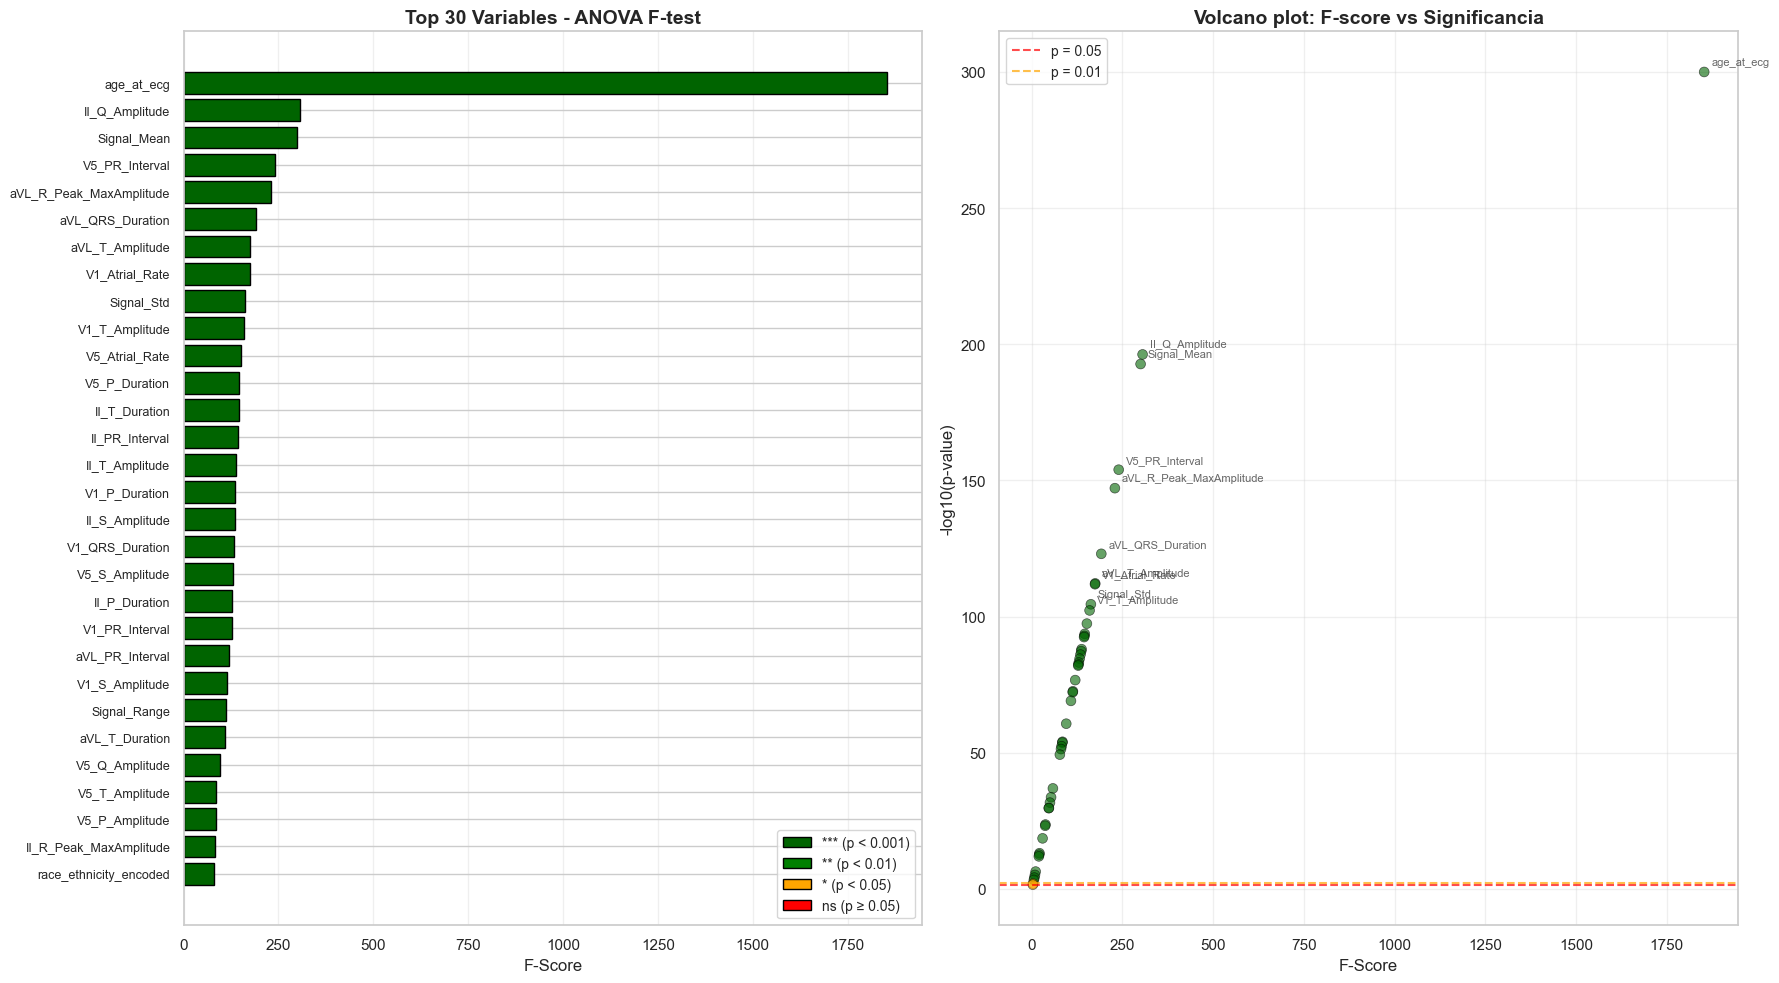

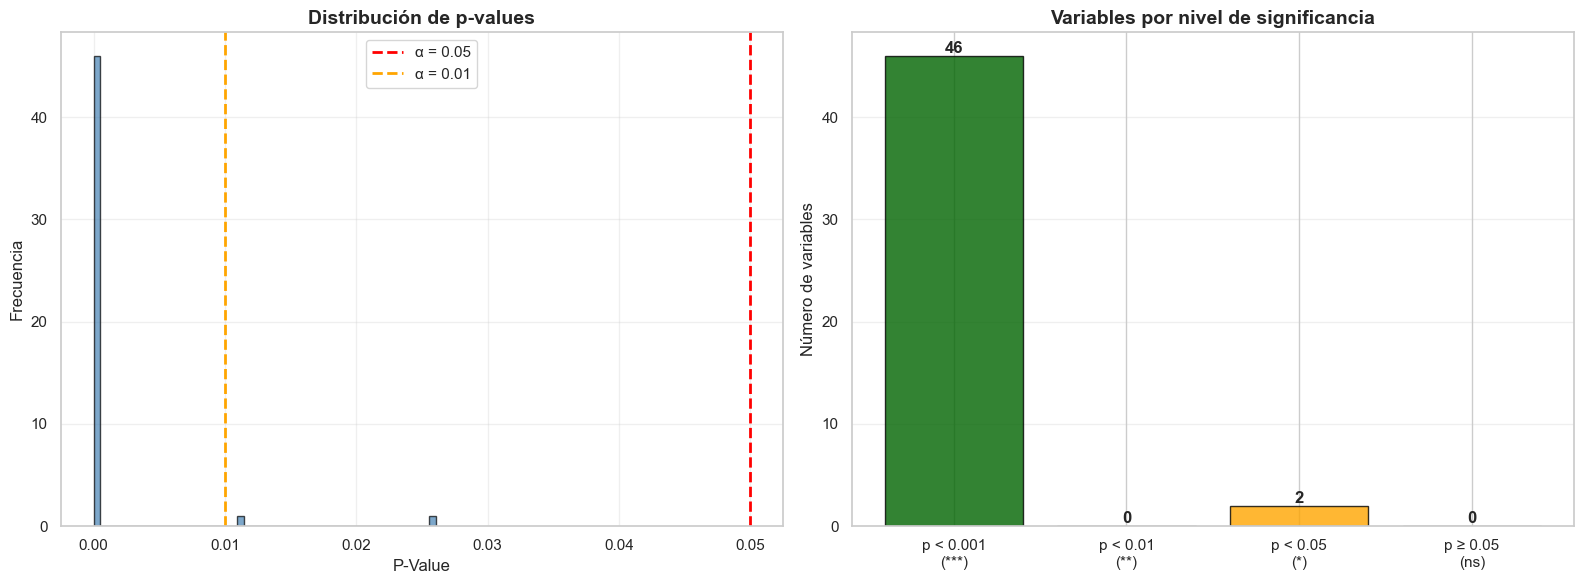

Criterio: p-value < 0.05
Variables seleccionadas: 48 de 48
Mapeo de cardiopatía cargado desde: D:\Desarrollo\TFG\encoders_mapping.json


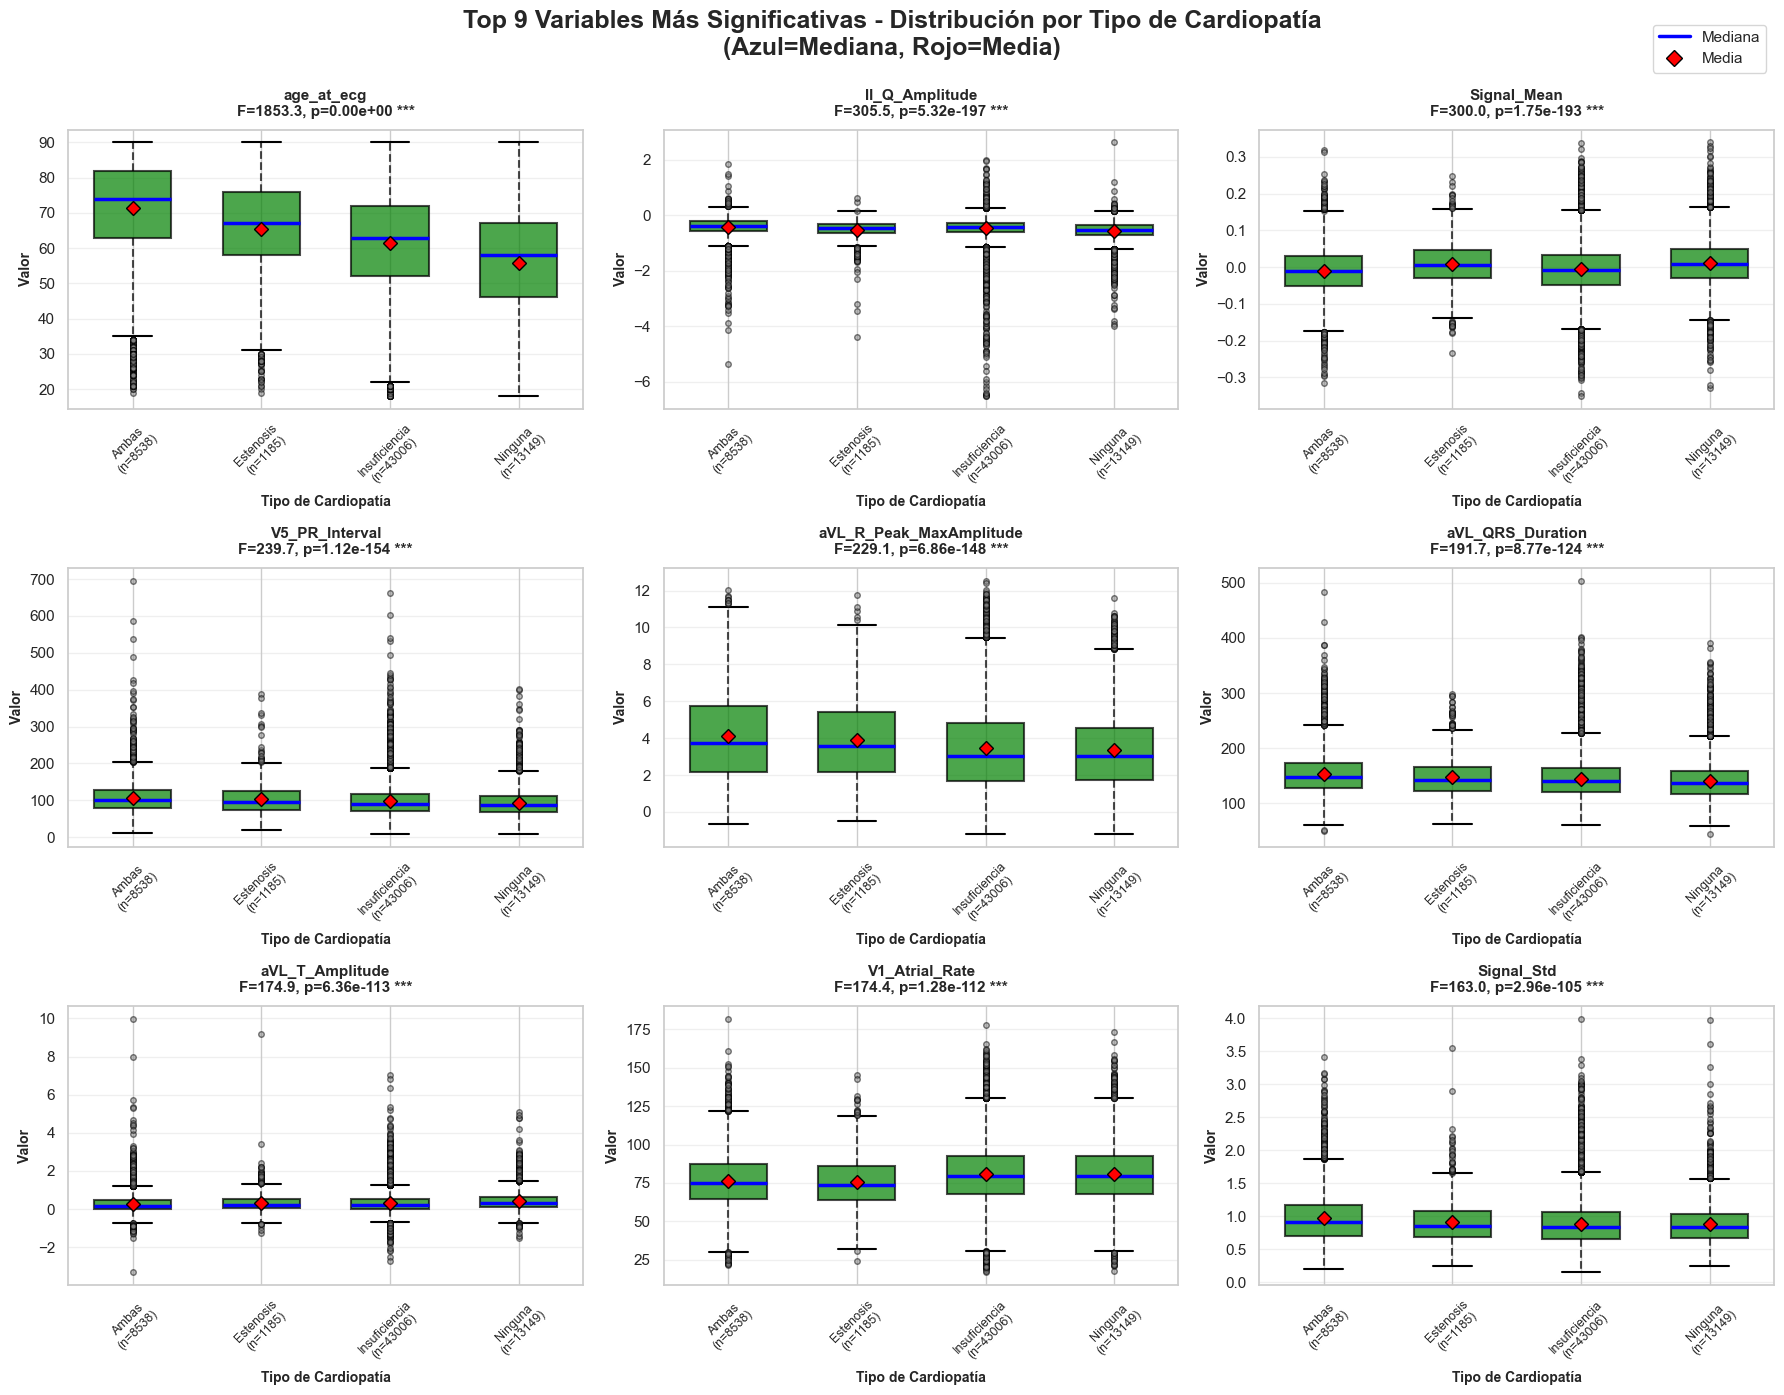

In [31]:
# Procedo a calcular ANOVA F-test
f_scores, p_values = f_classif(X_train_uncorr, y_train)

# Creo un df con los resultados
anova_results = pd.DataFrame({
    'Variable': X_train_uncorr.columns,
    'F_Score': f_scores,
    'P_Value': p_values,
    'Log10_P_Value': -np.log10(p_values + 1e-300)  # Para la visualización
}).sort_values('F_Score', ascending=False)

# Clasifico la significancia
def classify_significance(p):
    if p < 0.001:
        return '***'  # Altamente significativo
    elif p < 0.01:
        return '**'   # Muy significativo
    elif p < 0.05:
        return '*'    # Significativo
    else:
        return 'ns'   # No significativo

anova_results['Significancia'] = anova_results['P_Value'].apply(classify_significance)

# Preparo las estadísticas
n_highly_sig = (anova_results['P_Value'] < 0.001).sum()
n_very_sig = ((anova_results['P_Value'] >= 0.001) & (anova_results['P_Value'] < 0.01)).sum()
n_sig = ((anova_results['P_Value'] >= 0.01) & (anova_results['P_Value'] < 0.05)).sum()
n_not_sig = (anova_results['P_Value'] >= 0.05).sum()

print(f"Resultados de ANOVA F-test:")
print(f" - Variables altamente significativas (p < 0.001): {n_highly_sig} (***)")
print(f" - Variables muy significativas (p < 0.01): {n_very_sig} (**)")
print(f" - Variables significativas (p < 0.05): {n_sig} (*)")
print(f" - Variables no significativas (p ≥ 0.05): {n_not_sig} (ns)")
print(f"  - Total de variables significativas (p < 0.05): {n_highly_sig + n_very_sig + n_sig}")

# Muestro las 20 variables más significativas
print("20 variables más significativas:")
print(anova_results[['Variable', 'F_Score', 'P_Value', 'Significancia']].head(20).to_string(index=False))

# Muestro variables no significativas en el caso de haberlas
if n_not_sig > 0:
    print(f"Variables NO significativas (p ≥ 0.05):")
    not_sig_vars = anova_results[anova_results['P_Value'] >= 0.05]
    print(not_sig_vars[['Variable', 'F_Score', 'P_Value']].to_string(index=False))

# Visualizo los resultados de ANOVA
# Las 30 variables con mayor F-Score y el volcano plot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
# Gráfico 1: Top 30 variables por F-Score
top_30 = anova_results.head(30)
colors_sig = top_30['Significancia'].map({
    '***': 'darkgreen',
    '**': 'green',
    '*': 'orange',
    'ns': 'red'
})

bars = ax1.barh(range(len(top_30)), top_30['F_Score'], color=colors_sig, edgecolor='black')
ax1.set_yticks(range(len(top_30)))
ax1.set_yticklabels(top_30['Variable'], fontsize=9)
ax1.set_xlabel('F-Score', fontsize=12)
ax1.set_title('Top 30 Variables - ANOVA F-test', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, axis='x', alpha=0.3)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='darkgreen', edgecolor='black', label='*** (p < 0.001)'),
    Patch(facecolor='green', edgecolor='black', label='** (p < 0.01)'),
    Patch(facecolor='orange', edgecolor='black', label='* (p < 0.05)'),
    Patch(facecolor='red', edgecolor='black', label='ns (p ≥ 0.05)')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=10)

# Gráfico 2: Volcano plot (F-Score vs -log10(p-value))
scatter = ax2.scatter(anova_results['F_Score'], anova_results['Log10_P_Value'],
                     c=anova_results['Significancia'].map({
                         '***': 'darkgreen',
                         '**': 'green',
                         '*': 'orange',
                         'ns': 'gray'
                     }),
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

# Líneas de referencia
ax2.axhline(-np.log10(0.05), color='red', linestyle='--', linewidth=1.5, label='p = 0.05', alpha=0.7)
ax2.axhline(-np.log10(0.01), color='orange', linestyle='--', linewidth=1.5, label='p = 0.01', alpha=0.7)

ax2.set_xlabel('F-Score', fontsize=12)
ax2.set_ylabel('-log10(p-value)', fontsize=12)
ax2.set_title('Volcano plot: F-score vs Significancia', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Etiqueto las variables más significativas
top_10_vars = anova_results.head(10)
for idx, row in top_10_vars.iterrows():
    ax2.annotate(row['Variable'], 
                xy=(row['F_Score'], row['Log10_P_Value']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()
plt.close()

# Visualizo la distribución de p-values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histograma de p-values
ax1.hist(anova_results['P_Value'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
ax1.axvline(0.01, color='orange', linestyle='--', linewidth=2, label='α = 0.01')
ax1.set_xlabel('P-Value', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_title('Distribución de p-values', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Barplot de conteo por nivel de significancia
sig_counts = anova_results['Significancia'].value_counts()
colors_bar = {'***': 'darkgreen', '**': 'green', '*': 'orange', 'ns': 'gray'}
ordered_sig = ['***', '**', '*', 'ns']
sig_counts = sig_counts.reindex(ordered_sig, fill_value=0)

bars = ax2.bar(range(len(sig_counts)), sig_counts.values, 
              color=[colors_bar[s] for s in sig_counts.index],
              edgecolor='black', alpha=0.8)
ax2.set_xticks(range(len(sig_counts)))
ax2.set_xticklabels(['p < 0.001\n(***)', 'p < 0.01\n(**)', 'p < 0.05\n(*)', 'p ≥ 0.05\n(ns)'], fontsize=11)
ax2.set_ylabel('Número de variables', fontsize=12)
ax2.set_title('Variables por nivel de significancia', fontsize=14, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)

# Añado los valores sobre las barras
for i, (bar, count) in enumerate(zip(bars, sig_counts.values)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
plt.close()

# Selecciono las variables significativas
# Criterio de selección: p < 0.05
significance_threshold = 0.05
significant_features = anova_results[anova_results['P_Value'] < significance_threshold]['Variable'].tolist()

print(f"Criterio: p-value < {significance_threshold}")
print(f"Variables seleccionadas: {len(significant_features)} de {len(X_train_uncorr.columns)}")

# Aplico la selección a todos los datasets
X_train_anova = X_train_uncorr[significant_features]
X_val_anova = X_val_uncorr[significant_features]
X_cal_anova = X_cal_uncorr[significant_features]
X_test_anova = X_test_uncorr[significant_features]
del X_train_uncorr, X_val_uncorr, X_cal_uncorr, X_test_uncorr  # Libero la memoria

# Visualizo las distribuciones de las variables más significativas por clase
# Selecciono las 9 variables más significativas para visualizar
top_9_vars = anova_results.head(9)['Variable'].tolist()

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.ravel()

# Obtengo los nombres de las clases
try:
    json_path = os.path.join(DRIVE_PATH, 'encoders_mapping.json')
    with open(json_path, 'r') as f:
        encoders_mapping = json.load(f)
    
    # Converto keys de string a int
    class_names_dict = {int(k): v for k, v in encoders_mapping['cardiopatia'].items()}
    print(f"Mapeo de cardiopatía cargado desde: {json_path}")
    
except FileNotFoundError:
    print(" Se usarán etiquetas numéricas genéricas.")
    # Fallback: usar nombres genéricos
    unique_classes_in_train = sorted(y_train.unique())
    class_names_dict = {cls: f'Clase {cls}' for cls in unique_classes_in_train}

# Obtenego las clases únicas presentes en y_train y sus nombres
unique_classes = sorted(y_train.unique())
class_names_labels = [class_names_dict[cls] for cls in unique_classes]

for i, var in enumerate(top_9_vars):
    # Datos y etiquetas por clase
    data_by_class = [X_train_anova[var][y_train == cls].values for cls in unique_classes]
    labels_with_info = [f"{class_names_dict[cls]}\n(n={len(data)})" 
                        for cls, data in zip(unique_classes, data_by_class)]
    
    # Boxplot
    bp = axes[i].boxplot(data_by_class, 
                        tick_labels=labels_with_info,  # Nombres reales
                        patch_artist=True,
                        widths=0.6,
                        showmeans=True, 
                        meanprops=dict(marker='D', markerfacecolor='red', 
                                      markersize=7, markeredgecolor='black'))
    
    # Coloreo las cajas
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)
    
    # Mejoro el estilo de otros elementos del boxplot
    for whisker in bp['whiskers']:
        whisker.set(linewidth=1.5, linestyle='--', alpha=0.7)
    for cap in bp['caps']:
        cap.set(linewidth=1.5)
    for median in bp['medians']:
        median.set(color='blue', linewidth=2.5)
    for flier in bp['fliers']:
        flier.set(marker='o', markerfacecolor='gray', markersize=4, alpha=0.5)
    
    # Información estadística
    f_score = anova_results[anova_results['Variable'] == var]['F_Score'].values[0]
    p_val = anova_results[anova_results['Variable'] == var]['P_Value'].values[0]
    sig = anova_results[anova_results['Variable'] == var]['Significancia'].values[0]
    
    axes[i].set_title(f'{var}\nF={f_score:.1f}, p={p_val:.2e} {sig}', 
                     fontsize=11, fontweight='bold', pad=10)
    axes[i].set_ylabel('Valor', fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Tipo de Cardiopatía', fontsize=10, fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='y')
    
    # Roto las etiquetas si son largas
    axes[i].tick_params(axis='x', rotation=45, labelsize=9)

# Añado la leyenda para media y mediana
legend_elements = [
    plt.Line2D([0], [0], color='blue', linewidth=2.5, label='Mediana'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='red', 
               markersize=8, markeredgecolor='black', label='Media')
]
fig.legend(handles=legend_elements, loc='upper right', fontsize=11, 
          bbox_to_anchor=(0.99, 0.99))

plt.suptitle('Top 9 Variables Más Significativas - Distribución por Tipo de Cardiopatía\n' +
             '(Azul=Mediana, Rojo=Media)', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
plt.close()

**Resumen final**

Pipeline de Selección de Características:
                             Paso  N_Features  Features_Eliminadas  Reduccion_Pct
                       0. Inicial          62                    0           0.00
   1. Después de Outlier Analysis          62                    0           0.00
 2. Después de Variance Threshold          62                    0           0.00
3. Después de Correlation Removal          48                   14          22.58
       4. Después de ANOVA F-test          48                    0          22.58
Reducción total:
 - 62 → 48 variables
 - Reducción: 14 variables (22.6%)


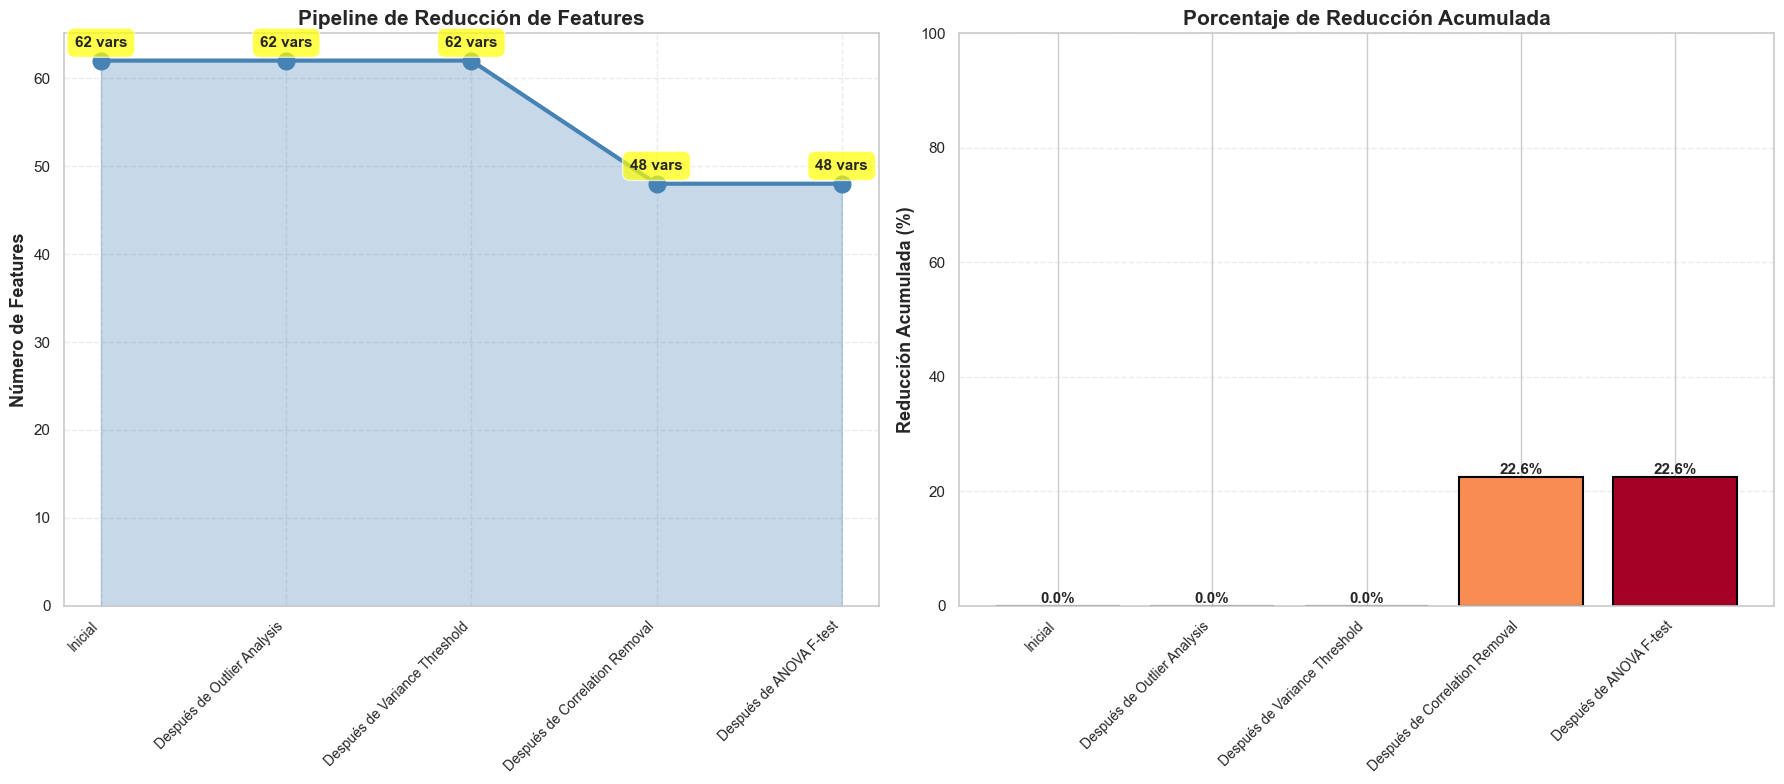

Datasets guardados en: D:\Desarrollo\TFG\
 - X_train_selected.csv: (65878, 48)
 - X_val_selected.csv: (2053, 48)
 - X_cal_selected.csv: (2053, 48)
 - X_test_selected.csv: (4815, 48)
 - y_train.csv, y_val.csv, y_cal.csv, y_test.csv
Características seleccionadas por categoría:
Demográficas        :  3 /  3 (100.0%)
 - age_at_ecg
 - sex_encoded
 - race_ethnicity_encoded
Derivación II       : 10 / 10 (100.0%)
 - II_T_Amplitude
 - II_PR_Interval
 - II_QT_Corrected
 - II_R_Peak_MaxAmplitude
 - II_Q_Amplitude
 - II_P_Amplitude
 - II_T_Duration
 - II_S_Amplitude
 - II_P_Duration
 - II_QRS_Duration
Derivación V1       : 11 / 11 (100.0%)
 - V1_P_Duration
 - V1_R_Peak_MaxAmplitude
 - V1_QT_Corrected
 - V1_S_Amplitude
 - V1_P_Amplitude
 - V1_Q_Amplitude
 - V1_QRS_Duration
 - V1_PR_Interval
 - V1_T_Duration
 - V1_Atrial_Rate
 - V1_T_Amplitude
Derivación V5       : 11 / 11 (100.0%)
 - V5_PR_Interval
 - V5_QRS_Duration
 - V5_R_Peak_MaxAmplitude
 - V5_P_Amplitude
 - V5_S_Amplitude
 - V5_P_Duration
 - 

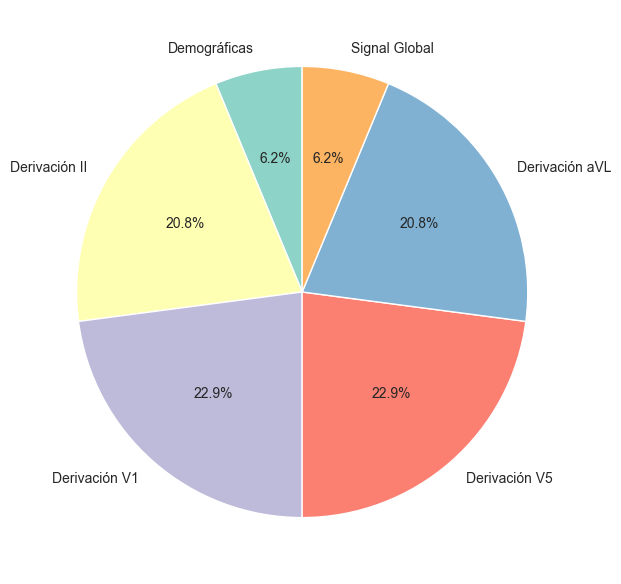

In [32]:
# Resumen final de características seleccionadas
final_features = list(set(significant_features))

X_train_final = X_train_anova[final_features]
X_val_final = X_val_anova[final_features]
X_cal_final = X_cal_anova[final_features]
X_test_final = X_test_anova[final_features]

summary = {
    'Paso': [
        '0. Inicial',
        '1. Después de Outlier Analysis',
        '2. Después de Variance Threshold',
        '3. Después de Correlation Removal',
        '4. Después de ANOVA F-test'
    ],
    'N_Features': [
        len(all_features),
        len(all_features),  # No se eliminan outliers
        len(selected_variance_features),
        len(selected_uncorr_features),
        len(significant_features)
    ],
    'Features_Eliminadas': [
        0,
        0,
        len(all_features) - len(selected_variance_features),
        len(selected_variance_features) - len(selected_uncorr_features),
        len(selected_uncorr_features) - len(significant_features)
    ]
}

summary_df = pd.DataFrame(summary)
summary_df['Reduccion_Pct'] = ((summary_df['N_Features'].iloc[0] - summary_df['N_Features']) / summary_df['N_Features'].iloc[0] * 100).round(2)

print("Pipeline de Selección de Características:")
print(summary_df.to_string(index=False))

print(f"Reducción total:")
print(f" - {len(all_features)} → {len(final_features)} variables")
print(f" - Reducción: {len(all_features) - len(final_features)} variables ({summary_df['Reduccion_Pct'].iloc[-1]:.1f}%)")

# Visualización del pipeline completo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico 1: Cascada de reducción de features
steps = summary_df['Paso'].tolist()
n_features = summary_df['N_Features'].tolist()

ax1.plot(range(len(steps)), n_features, marker='o', linewidth=3, markersize=12, color='steelblue')
ax1.fill_between(range(len(steps)), n_features, alpha=0.3, color='steelblue')

# Anoto cada punto
for i, (step, n) in enumerate(zip(steps, n_features)):
    ax1.annotate(f'{n} vars', 
                xy=(i, n), 
                xytext=(0, 10), 
                textcoords='offset points',
                ha='center', 
                fontsize=11, 
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax1.set_xticks(range(len(steps)))
ax1.set_xticklabels([s.split('. ')[1] if '. ' in s else s for s in steps], 
                    rotation=45, ha='right', fontsize=10)
ax1.set_ylabel('Número de Features', fontsize=13, fontweight='bold')
ax1.set_title('Pipeline de Reducción de Features', fontsize=15, fontweight='bold')
ax1.grid(True, alpha=0.4, linestyle='--')
ax1.set_ylim(bottom=0)

# Gráfico 2: Reducción acumulada en porcentaje
reduction_pct = summary_df['Reduccion_Pct'].tolist()
colors_gradient = plt.cm.RdYlGn_r(np.linspace(0, 1, len(steps)))

bars = ax2.bar(range(len(steps)), reduction_pct, color=colors_gradient, edgecolor='black', linewidth=1.5)

# Anoto las barras
for i, (bar, pct) in enumerate(zip(bars, reduction_pct)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_xticks(range(len(steps)))
ax2.set_xticklabels([s.split('. ')[1] if '. ' in s else s for s in steps], 
                    rotation=45, ha='right', fontsize=10)
ax2.set_ylabel('Reducción Acumulada (%)', fontsize=13, fontweight='bold')
ax2.set_title('Porcentaje de Reducción Acumulada', fontsize=15, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.4, linestyle='--')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()
plt.close()

# Guardo los dataset finales
# Guardo los ficheros de características finales
X_train_final.to_csv(os.path.join(DRIVE_PATH, 'X_train_selected.csv'), index=False)
X_val_final.to_csv(os.path.join(DRIVE_PATH, 'X_val_selected.csv'), index=False)
X_cal_final.to_csv(os.path.join(DRIVE_PATH, 'X_cal_selected.csv'), index=False)
X_test_final.to_csv(os.path.join(DRIVE_PATH, 'X_test_selected.csv'), index=False)

# Guardo los ficheros de target finales
y_train.to_csv(os.path.join(DRIVE_PATH, 'y_train.csv'), index=False, header=['cardiopatia_encoded'])
y_val.to_csv(os.path.join(DRIVE_PATH, 'y_val.csv'), index=False, header=['cardiopatia_encoded'])
y_cal.to_csv(os.path.join(DRIVE_PATH, 'y_cal.csv'), index=False, header=['cardiopatia_encoded'])
y_test.to_csv(os.path.join(DRIVE_PATH, 'y_test.csv'), index=False, header=['cardiopatia_encoded'])

print(f"Datasets guardados en: {DRIVE_PATH}")
print(f" - X_train_selected.csv: {X_train_final.shape}")
print(f" - X_val_selected.csv: {X_val_final.shape}")
print(f" - X_cal_selected.csv: {X_cal_final.shape}")
print(f" - X_test_selected.csv: {X_test_final.shape}")
print(f" - y_train.csv, y_val.csv, y_cal.csv, y_test.csv")

# Visualización final
# Uno todos los resultados
final_ranking = anova_results[['Variable', 'F_Score', 'P_Value']].copy()
final_ranking = final_ranking.merge(
    outliers_full[['Variable', 'Pct_Outliers']], 
    on='Variable', 
    how='left'
)

# Categorizo las características por derivación y tipo
categories = {
    'Demográficas': ['age_at_ecg', 'sex_encoded', 'race_ethnicity_encoded'],
    'Derivación II': [f for f in final_features if f.startswith('II_')],
    'Derivación V1': [f for f in final_features if f.startswith('V1_')],
    'Derivación V5': [f for f in final_features if f.startswith('V5_')],
    'Derivación aVL': [f for f in final_features if f.startswith('aVL_')],
    'Signal Global': [f for f in final_features if f.startswith('Signal_')]
}

print("Características seleccionadas por categoría:")
for category, features in categories.items():
    selected_in_cat = [f for f in features if f in final_features]
    total_in_cat = len(features)
    print(f"{category:20s}: {len(selected_in_cat):2d} / {total_in_cat:2d} ({len(selected_in_cat)/total_in_cat*100:.1f}%)")
    for feat in selected_in_cat:
         print(f" - {feat}")

# Pie chart de distribución
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

cat_names = list(categories.keys())
cat_counts = [len([f for f in features if f in final_features]) for features in categories.values()]

colors_pie = plt.cm.Set3(range(len(cat_names)))
wedges, texts, autotexts = ax.pie(cat_counts, labels=cat_names, autopct='%1.1f%%',
                                    colors=colors_pie, startangle=90,
                                    textprops={'fontsize': 10})

ax2.set_title('Distribución de las características seleccionadas', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
plt.close()

# Bibliografía

<mark>Pendiente de formatear y numerar de forma correcta</mark>

***[1] D. Makowski, T. Pham, Z. J. Lau, J. C. Brammer, F. Les, C. Schölzel y S. H. A. Chen, "NeuroKit2: A Python toolbox for neurophysiological signal processing" Behavior Research Method, vol. 53, pp. 1689-1696, 2021.***

***[2] J. Pan y W. J. Tompkins,  "A real-time QRS detection algorithm.", IEEE Transactions on Biomedical Engineering, BME-32(3), pp. 230-236, 1985.***

***[3] O. Singh y R. K. Sunkaria, "A robust QRS detection algorithm for noisy ECG signals using novel pre-processing techniques." Biomedical Signal Processing and Control, 43, pp. 186-197, 2018.***

***[4] J. P. Martínez, R. Almeida, S. Olmos, A. P. Rocha y P, Laguna, "A wavelet-based ECG delineator: Evaluation on standard databases.", IEEE Transactions on Biomedical Engineering, 2004.***

***[5] Moloy, P. J., Okin, P. M., Devereux, R. B., et al. (1992).Electrocardiographic detection of left ventricular hypertrophy: Cornell voltage criteria. Journal of the American College of Cardiology.***

***[6] Liu, C., Li, P., Zhao, L., et al. (2018). Signal quality assessment and arrhythmia classification using morphological features and random forest. Computers in Biology and Medicine.***

***[7] Sörnmo & Laguna, Bioelectrical Signal Processing in Cardiac and Neurological Applications NOTA: Se recomienda incluir medidas globales del nivel de señal.***

***[8] Kuhn & Johnson. "Applied Predictive Modeling". Springer. NOTA: Recomienda umbrales threshold pequeños (1e-6 a 1e-4) para datos biomédicos.***

***[9] Dormann et al. (2013). “Collinearity: a review of methods to deal with it”.→ Recomienda 0.90 como corte estándar.***

***[10] "The Elements of Statistical Learning" (Hastie, Tibshirani, Friedman)***

***[11] "CatBoost: unbiased boosting with categorical features" (Prokhorenkova et al., 2018)***

***[12] "Bias in random forest variable importance measures: Illustrations, sources and a solution" (Strobl et al., 2007)***

***[13] Rich Caruana et al. (2004), Stratified splitting to preserve class balance***

***[14] A comparative study of imputation techniques for missing values in healthcare diagnostic datasets. Luke Oluwaseye Joel1 · Wesley Doorsamy2 · Babu Sena Paul2 Received: 23 October 2024 / Accepted: 20 May 2025 / Published online: 11 June 2025 https://doi.org/10.1007/s41060-025-00825-9***

***[15] Beretta, L., Santaniello, A. Nearest neighbor imputation algorithms: a critical evaluation. BMC Med Inform Decis Mak 16 (Suppl 3), 74 (2016). https://doi.org/10.1186/s12911-016-0318-z***

***[16] Aguinis, H., Gottfredson, R. K., & Joo, H. (2013). "Best-practice recommendations for defining, identifying, and handling outliers." Organizational Research Methods, 16(2), 270-301.***

***[17] Kohavi, R., & John, G. H. (1997). "Wrappers for feature subset selection." Artificial Intelligence, 97(1-2), 273-324.***

***[18] Dormann, C. F., et al. (2013). "Collinearity: a review of methods to deal with it and a simulation study evaluating their performance." Ecography, 36(1), 27-46.***

***[19] Saeys, Y., Inza, I., & Larrañaga, P. (2007). "A review of feature selection techniques in bioinformatics." Bioinformatics, 23(19), 2507-2517.***




***********************************************************